In [1]:
# Imports
import itertools
from keras.layers import BatchNormalization, Dense, Dropout, Flatten, LSTM
from keras.models import Sequential
from keras.regularizers import l1, l1_l2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [2]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        thresh = cm.max() / 2.
                                                 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
# Don't run this block of code if you aren't using Tensorflow-GPU.
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices------------- 1


In [4]:
# Reading the dataset.
cpu_utilization = pd.read_csv('ec2_cpu_utilization_5f5533.csv')
cpu_utilization.set_index('timestamp', inplace=True)

In [5]:
# Statistics about the original dataset.
print('\nCPU Utilization Dataset Shape:', cpu_utilization.shape)
print('\nFirst 5 rows of the CPU Utilization Dataset:\n', cpu_utilization.head())
print('\nCPU Utilization Dataset description:\n', cpu_utilization.describe())


CPU Utilization Dataset Shape: (4032, 1)

First 5 rows of the CPU Utilization Dataset:
                       value
timestamp                  
2014-02-14 14:27:00  51.846
2014-02-14 14:32:00  44.508
2014-02-14 14:37:00  41.244
2014-02-14 14:42:00  48.568
2014-02-14 14:47:00  46.714

CPU Utilization Dataset description:
              value
count  4032.000000
mean     43.110372
std       4.303565
min      34.766000
25%      39.296000
50%      42.918000
75%      46.006000
max      68.092000


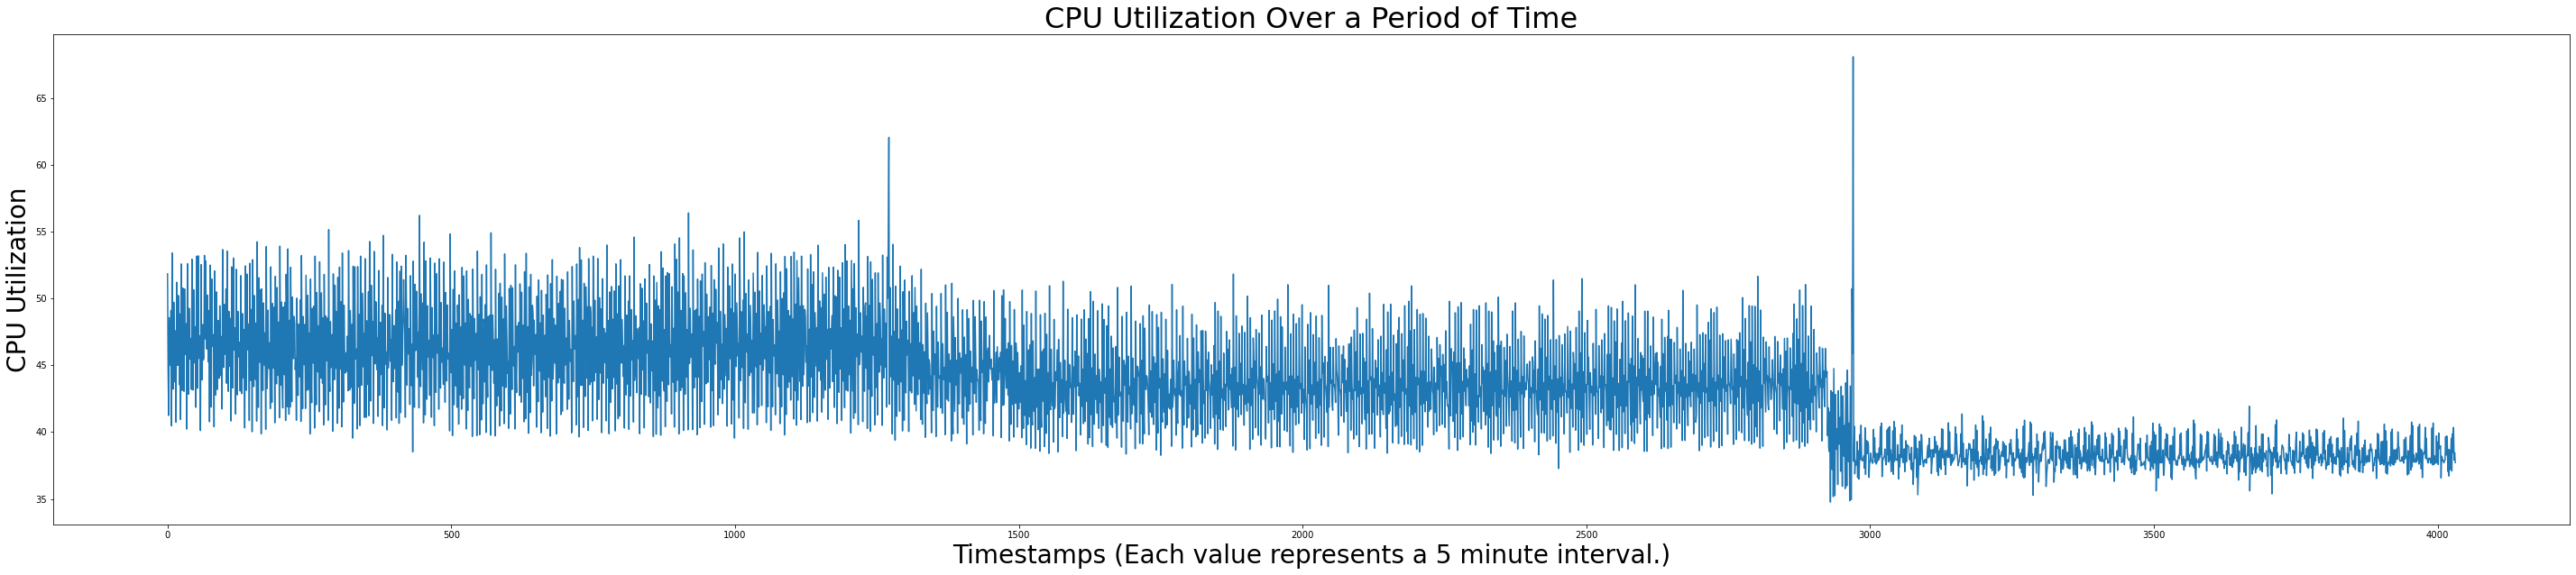

In [6]:
# Visualizing the original data.
plt.figure(figsize=(50, 10))
plt.plot(cpu_utilization['value'].values)
plt.xlabel('Timestamps (Each value represents a 5 minute interval.)', fontsize=28)
plt.ylabel('CPU Utilization', fontsize=28)
plt.title('CPU Utilization Over a Period of Time', fontsize=32)
plt.show()

When CPU Utilization goes over 60 % AWS stars a new machine to prevent putting too much load on a single machine. Thus, we are treating loads above 60 % as being anomalies.

In [7]:
# Replacing the anomalies with the median value and creating a dataset with normal values.
normal_cpu_utilization = cpu_utilization.copy()
for i in range(len(cpu_utilization['value'])):
    if cpu_utilization['value'].iloc[i] > 60.0:
        normal_cpu_utilization['value'].iloc[i] = cpu_utilization['value'].median()

In [8]:
# Statistics about the normal dataset.
print('\nNormal CPU Utilization Dataset Shape:', normal_cpu_utilization.shape)
print('\nFirst 5 rows of the Normal CPU Utilization Dataset:\n', normal_cpu_utilization.head())
print('\nNormal CPU Utilization Dataset description:\n', normal_cpu_utilization.describe())


Normal CPU Utilization Dataset Shape: (4032, 1)

First 5 rows of the Normal CPU Utilization Dataset:
                       value
timestamp                  
2014-02-14 14:27:00  51.846
2014-02-14 14:32:00  44.508
2014-02-14 14:37:00  41.244
2014-02-14 14:42:00  48.568
2014-02-14 14:47:00  46.714

Normal CPU Utilization Dataset description:
              value
count  4032.000000
mean     43.099382
std       4.275126
min      34.766000
25%      39.296000
50%      42.918000
75%      45.986500
max      56.408000


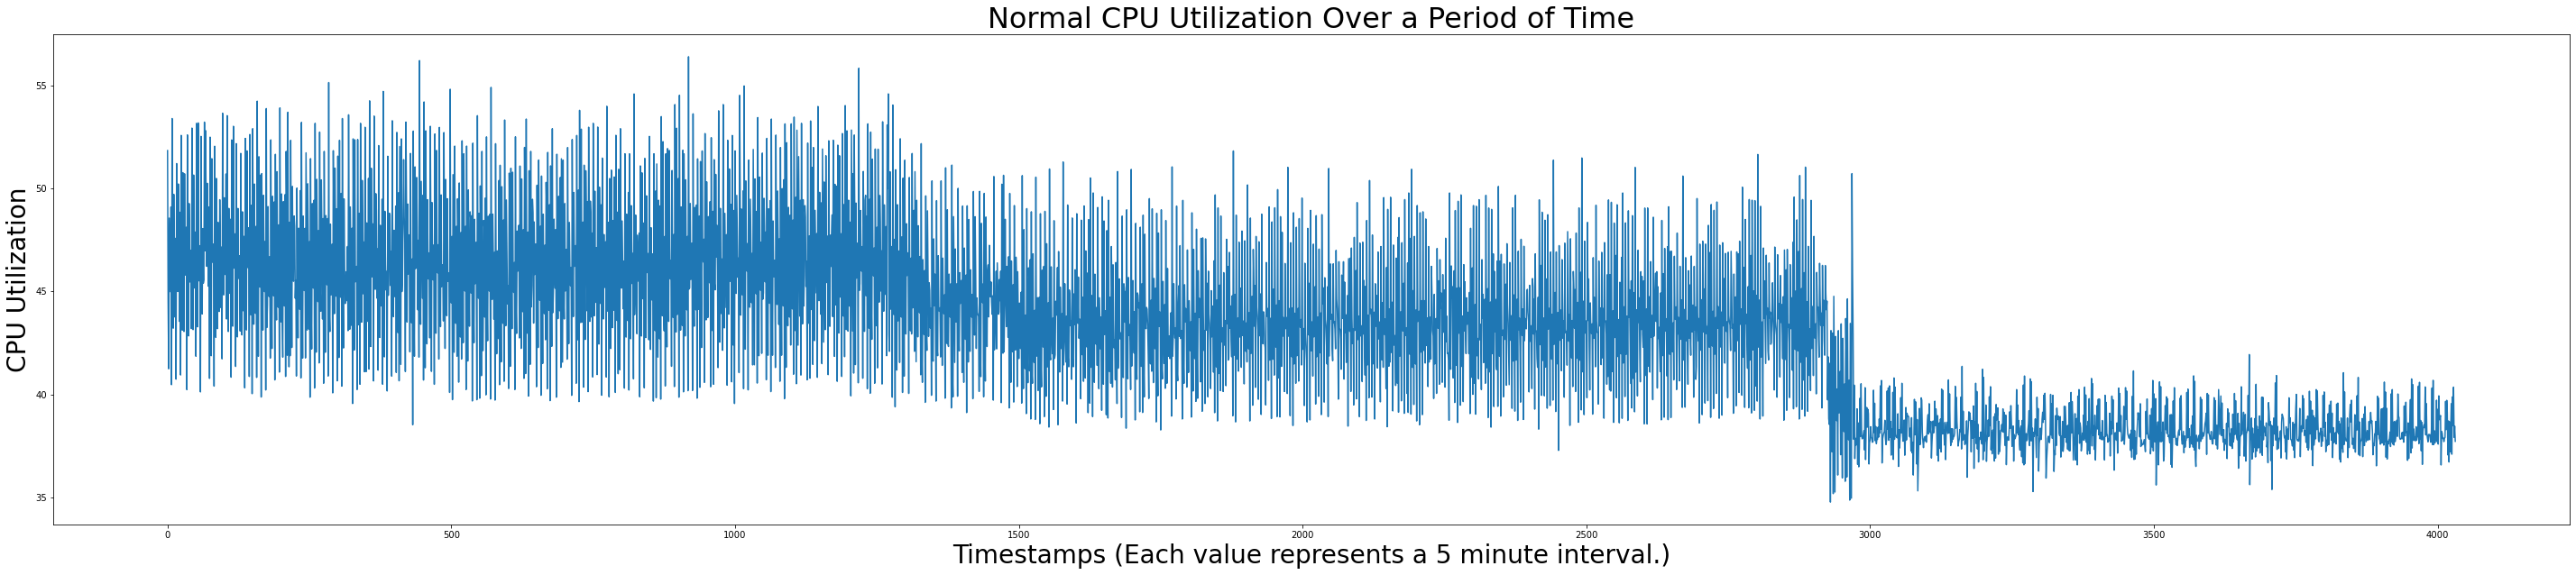

In [9]:
# Visualizing the normal data.
plt.figure(figsize=(50, 10))
plt.plot(normal_cpu_utilization['value'].values)
plt.xlabel('Timestamps (Each value represents a 5 minute interval.)', fontsize=28)
plt.ylabel('CPU Utilization', fontsize=28)
plt.title('Normal CPU Utilization Over a Period of Time', fontsize=32)
plt.show()

In [10]:
# Normalizing the data.
normal_cpu_utilization = normal_cpu_utilization.values
scaler = MinMaxScaler()
normal_cpu_utilization = scaler.fit_transform(normal_cpu_utilization)

In [11]:
# Creating the labels for plotting the confusion matrix.
cpu_utilization.insert(1, 'Label', '')
for i in range(len(cpu_utilization)):
    if cpu_utilization['value'][i] > 60.0: # Remember we have assumed valued over 60 to be anomalous.
        cpu_utilization['Label'][i] = 'anomaly'
    else:
        cpu_utilization['Label'][i] = 'normal'

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [12]:
print('First 5 rows of the dataset after creating the labels:\n', cpu_utilization.head())

First 5 rows of the dataset after creating the labels:
                       value   Label
timestamp                          
2014-02-14 14:27:00  51.846  normal
2014-02-14 14:32:00  44.508  normal
2014-02-14 14:37:00  41.244  normal
2014-02-14 14:42:00  48.568  normal
2014-02-14 14:47:00  46.714  normal


# MLP Model #1

In [13]:
# Specifying the window and prediction parameters.
window = 10
predict = 5

In [14]:
# Creating the lists to store the data and the labels.
x = []
y = []
for i in range(window, len(normal_cpu_utilization) + 1):
    x.append(normal_cpu_utilization[i-window:i, 0])

for i in range(predict, len(normal_cpu_utilization) + 1):
    y.append(normal_cpu_utilization[i-predict:i, 0])
    
x = x[:-predict]
y = y[window:]

In [15]:
# Printing some statistics about the data.
print('Shape X:', len(x))
print('Shape Y:', len(y))
print('Maximum Data Value:', np.max(x))

Shape X: 4018
Shape Y: 4018
Maximum Data Value: 1.0


In [16]:
# Converting to array.
x = np.array(x)
y = np.array(y)

In [17]:
# Creating the train and test dataset.
x_train = x[:int(0.7 * len(x))]
y_train = y[:int(0.7 * len(y))]

x_test = x[int(0.7 * len(x)):]
y_test = y[int(0.7 * len(y)):]

In [18]:
# Printing some statistics about the data.
print('\nShape of the training dataset:', x_train.shape)
print('\n2 First two rows of the training data:\n', x_train[:2])
print('\n2 Last two rows of the training data:\n', x_train[-2:])

print('\nShape of the testing dataset:', x_test.shape)
print('\n2 First two rows of the testing data:\n', x_test[:2])
print('\n2 Last two rows of the testing data:\n', x_test[-2:])

print('\nShape of training data labels:', y_train.shape)
print('\n2 First two rows of the training data labels:\n', y_train[:2])
print('\n2 Last two rows of the training data labels:\n', y_train[-2:])

print('\nShape of testing data labels:', y_test.shape)
print('\n2 First two rows of the testing data labels:\n', y_test[:2])
print('\n2 Last two rows of the testing data labels:\n', y_test[-2:])


Shape of the training dataset: (2812, 10)

2 First two rows of the training data:
 [[0.78920617 0.45014324 0.29932539 0.63774143 0.55207467 0.47222992
  0.66269291 0.26356159 0.86119582 0.49135939]
 [0.45014324 0.29932539 0.63774143 0.55207467 0.47222992 0.66269291
  0.26356159 0.86119582 0.49135939 0.39044451]]

2 Last two rows of the training data:
 [[0.40458368 0.19305055 0.57046484 0.41216154 0.49671934 0.41105258
  0.31124665 0.55420017 0.42186489 0.43600407]
 [0.19305055 0.57046484 0.41216154 0.49671934 0.41105258 0.31124665
  0.55420017 0.42186489 0.43600407 0.33943258]]

Shape of the testing dataset: (1206, 10)

2 First two rows of the testing data:
 [[0.57046484 0.41216154 0.49671934 0.41105258 0.31124665 0.55420017
  0.42186489 0.43600407 0.33943258 0.31910175]
 [0.41216154 0.49671934 0.41105258 0.31124665 0.55420017 0.42186489
  0.43600407 0.33943258 0.31910175 0.53682654]]

2 Last two rows of the testing data:
 [[0.2285371  0.20062841 0.10581277 0.18214583 0.09001017 0.180

In [19]:
# MLP Model #1 with the loss as 'Mean Absolute Error'.
model = Sequential()
model.add(Dense(256))
model.add(Dropout(0.2))
model.add(Dense(196))
model.add(Dropout(0.2))
model.add(Dense(predict))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])

In [20]:
# Fitting the MLP model on the training data.
history = model.fit(x_train, y_train, epochs=50, batch_size=16, verbose=1, validation_data=(x_test, y_test))

Epoch 1/50
176/176 [==============================] - 0s 2ms/step - loss: 0.1264 - accuracy: 0.4548 - val_loss: 0.0519 - val_accuracy: 0.2380
Epoch 2/50
176/176 [==============================] - 0s 2ms/step - loss: 0.1022 - accuracy: 0.5484 - val_loss: 0.0564 - val_accuracy: 0.2272
Epoch 3/50
176/176 [==============================] - 0s 2ms/step - loss: 0.0990 - accuracy: 0.5605 - val_loss: 0.0567 - val_accuracy: 0.2231
Epoch 4/50
176/176 [==============================] - 0s 2ms/step - loss: 0.0963 - accuracy: 0.5669 - val_loss: 0.0520 - val_accuracy: 0.2405
Epoch 5/50
176/176 [==============================] - 0s 2ms/step - loss: 0.0960 - accuracy: 0.5729 - val_loss: 0.0555 - val_accuracy: 0.2272
Epoch 6/50
176/176 [==============================] - 0s 2ms/step - loss: 0.0942 - accuracy: 0.5789 - val_loss: 0.0539 - val_accuracy: 0.2438
Epoch 7/50
176/176 [==============================] - 0s 2ms/step - loss: 0.0940 - accuracy: 0.5868 - val_loss: 0.0528 - val_accuracy: 0.2280
Epoch 

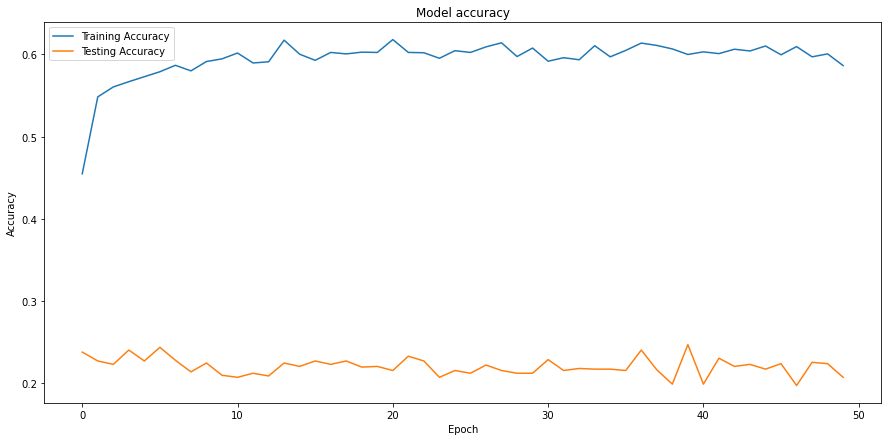

In [21]:
# Plot Accuracy.
plt.figure(figsize=(15, 7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='best')
plt.show()

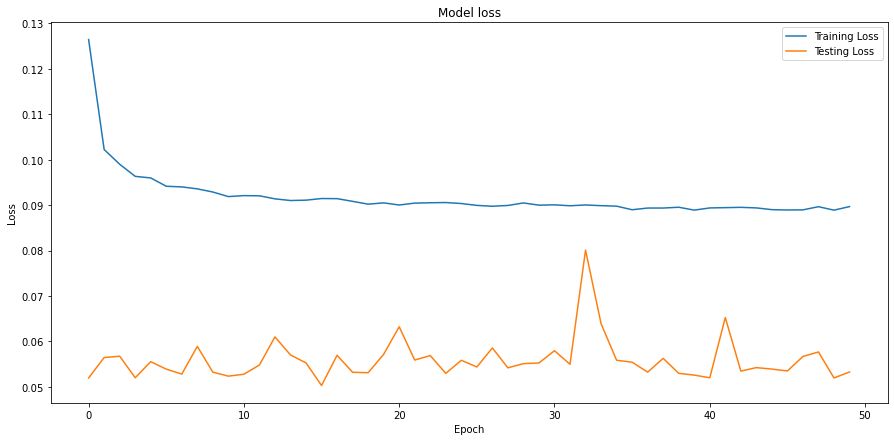

In [22]:
# Plot Loss.
plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Testing Loss'], loc='best')
plt.show()

In [23]:
# Making the predictions.
predictions = (model.predict(x_test))
predictions = scaler.inverse_transform(predictions)

print('Predictions Shape:', predictions.shape)
print('\nFirst 10 Predictions:\n', predictions[:10])
print('\nFirst 10 Actual Values:\n', scaler.inverse_transform(y_test[:10]))
print('\nLast 10 Predictions:\n', predictions[-10:])
print('\nLast 10 Actual Values:\n', scaler.inverse_transform(y_test[-10:]))

Predictions Shape: (1206, 5)

First 10 Predictions:
 [[46.03802  43.64189  43.673534 43.979687 43.41094 ]
 [43.475586 42.590397 44.8527   42.439415 44.908154]
 [42.222313 44.165024 42.624763 44.650356 43.42216 ]
 [43.909325 43.207226 44.690952 42.9748   44.056618]
 [43.73444  44.56624  42.924034 44.049053 43.692673]
 [45.17153  43.12033  43.709816 43.50668  42.805397]
 [43.43747  42.543755 44.18056  42.058884 43.35581 ]
 [41.678574 44.28129  42.510544 42.87147  44.669044]
 [43.723305 43.005985 42.795666 44.33324  43.75492 ]
 [43.776524 43.752    43.663826 44.239536 42.577793]]

First 10 Actual Values:
 [[46.384 43.716 43.996 42.432 42.512]
 [43.716 43.996 42.432 42.512 44.108]
 [43.996 42.432 42.512 44.108 45.422]
 [42.432 42.512 44.108 45.422 43.616]
 [42.512 44.108 45.422 43.616 42.984]
 [44.108 45.422 43.616 42.984 40.212]
 [45.422 43.616 42.984 40.212 47.16 ]
 [43.616 42.984 40.212 47.16  43.568]
 [42.984 40.212 47.16  43.568 43.24 ]
 [40.212 47.16  43.568 43.24  42.868]]

Last 10 

In [24]:
# Getting the average value for all the predictions.
average_predictions = [predictions[0][0], (predictions[0][1] + predictions[1][0]) / 2,
                       (predictions[0][2] + predictions[1][1] + predictions[2][0]) / 3,
                       (predictions[0][3] + predictions[1][2] + predictions[2][1] + predictions[3][0]) / 4]

for i in range(len(predictions)-4):
    average_predictions.append((predictions[i][4] + predictions[i+1][3] + predictions[i+2][2] + predictions[i+3][1] + 
                                predictions[i+4][0])/5)

average_predictions.append((predictions[-1][1] + predictions[-2][2] + predictions[-3][3] + predictions[-4][4])/4)
average_predictions.append((predictions[-1][2] + predictions[-2][3] + predictions[-3][4])/3)
average_predictions.append((predictions[-1][3] + predictions[-2][4])/2)
average_predictions.append(predictions[-1][4])

print('\nAverage Predictions Length:', len(average_predictions))
# print('\nAverage Predictions:\n', average_predictions)


Average Predictions Length: 1210


In [25]:
# Calculating the errors. # Here we identify the anomalies using Absolute Error.

# Creating the comparison dataset.
comparison_cpu_utilization = cpu_utilization['value'].values[len(x_train) + window:]

print('Length of the comparison dataset:', len(comparison_cpu_utilization))

absolute_errors = []
for i in range(len(average_predictions)):
    absolute_errors.append(abs(comparison_cpu_utilization[i]-average_predictions[i]))

# Printing some statistics about the errors.
print('\nMaximum Absolute Error Value:', max(absolute_errors))
print('\nMinimum Absolute Error Value', min(absolute_errors))
print('\nMean Absolute Error Value:', np.mean(absolute_errors))
print('\nMedian Absolute Error Value:', np.median(absolute_errors))
print('\nStandard Deviation of Absolute Error Values:', np.std(absolute_errors))

# Calculating the threshold.
threshold = np.mean(absolute_errors) + 2 * np.std(absolute_errors)
print('\nThreshold:', threshold)

Length of the comparison dataset: 1210

Maximum Absolute Error Value: 28.405909912109372

Minimum Absolute Error Value 0.00016479492187215783

Mean Absolute Error Value: 1.068628297983385

Median Absolute Error Value: 0.8535781250000021

Standard Deviation of Absolute Error Values: 1.2141335887345401

Threshold: 3.4968954754524653


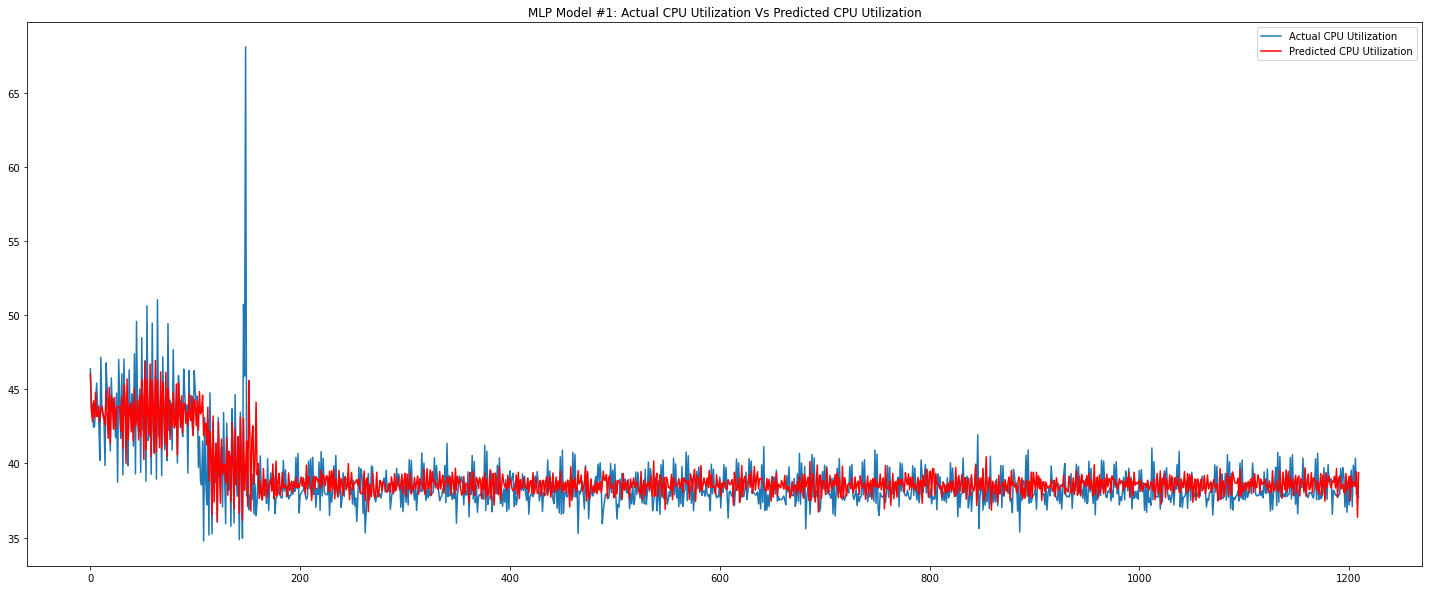

In [26]:
# Plotting Actual CPU Utilization vs Predicted CPU Utilization.
plt.figure(figsize=(25, 10))
plt.plot(comparison_cpu_utilization, label='Actual CPU Utilization')
plt.plot(average_predictions, label='Predicted CPU Utilization', color='red')
plt.legend()
plt.title('MLP Model #1: Actual CPU Utilization Vs Predicted CPU Utilization')
plt.show()

In [27]:
# Getting the anomaly indices.
anomalies = []
for absolute_error in absolute_errors:
    if absolute_error > threshold:
        anomalies.append(absolute_error)
        
print('Length of anomalies:', len(anomalies))

anomaly_indices = []
for anomaly in anomalies:
    anomaly_indices.append(absolute_errors.index(anomaly))
print('\nAnomaly Indices:', anomaly_indices)

Length of anomalies: 24

Anomaly Indices: [10, 26, 44, 54, 59, 64, 74, 105, 106, 108, 110, 111, 113, 146, 147, 148, 149, 151, 152, 154, 158, 465, 686, 886]


In [28]:
# Creating the anomalies dataset.
anomalies_dataset = []
for i in range(len(x_test) + predict - 1):
    if i in anomaly_indices:
        anomalies_dataset.append(comparison_cpu_utilization[i])
    else:
        anomalies_dataset.append(None)
        
# print((anomalies_dataset))

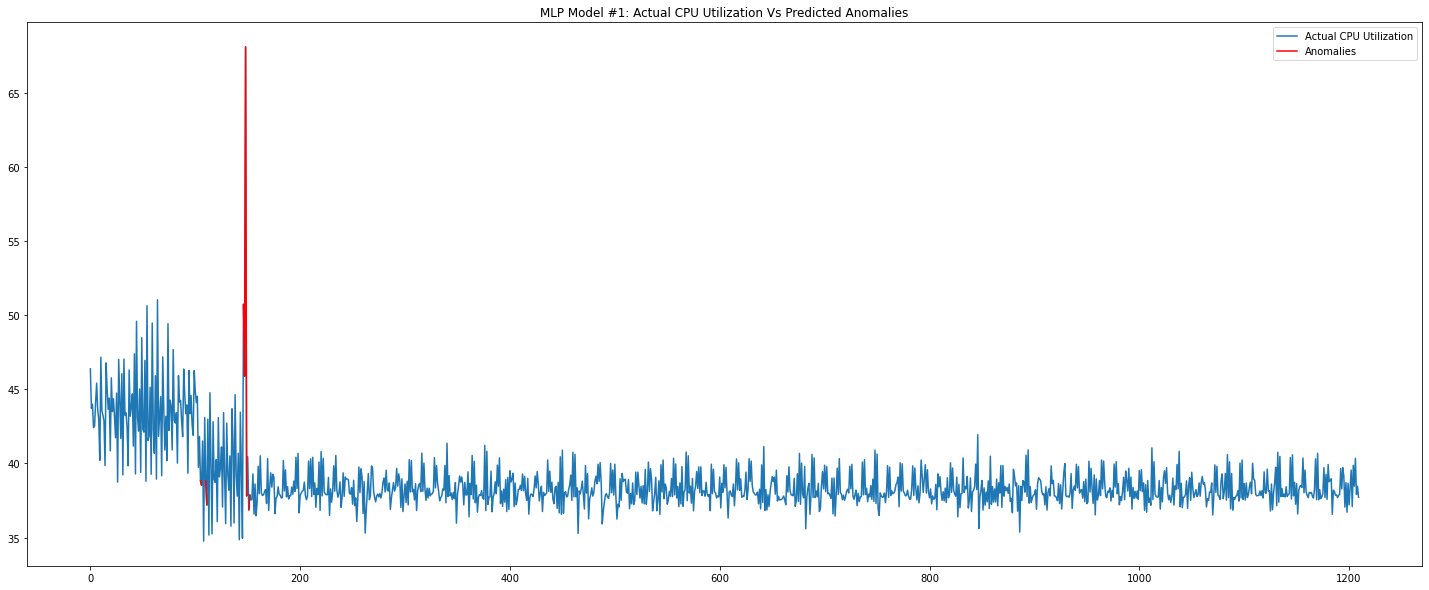

In [29]:
# Plotting Actual CPU Utilization vs Predicted Anomalies.
plt.figure(figsize=(25, 10))
plt.plot(comparison_cpu_utilization, label='Actual CPU Utilization')
plt.plot(anomalies_dataset, label='Anomalies', color='red')
plt.legend()
plt.title('MLP Model #1: Actual CPU Utilization Vs Predicted Anomalies')
plt.show()

In [30]:
# Getting the predicted classes for plotting the confusion matrix.
normal_anomaly_predictions = []
for i in range(len(x_test) + predict - 1):
    if i in anomaly_indices:
        normal_anomaly_predictions.append('anomaly')
    else:
        normal_anomaly_predictions.append('normal')

# Getting the hypothesized classes for plotting the confusion matrix.
comparison_cpu_utilization_label = cpu_utilization['Label'].values[len(x_train) + window:]

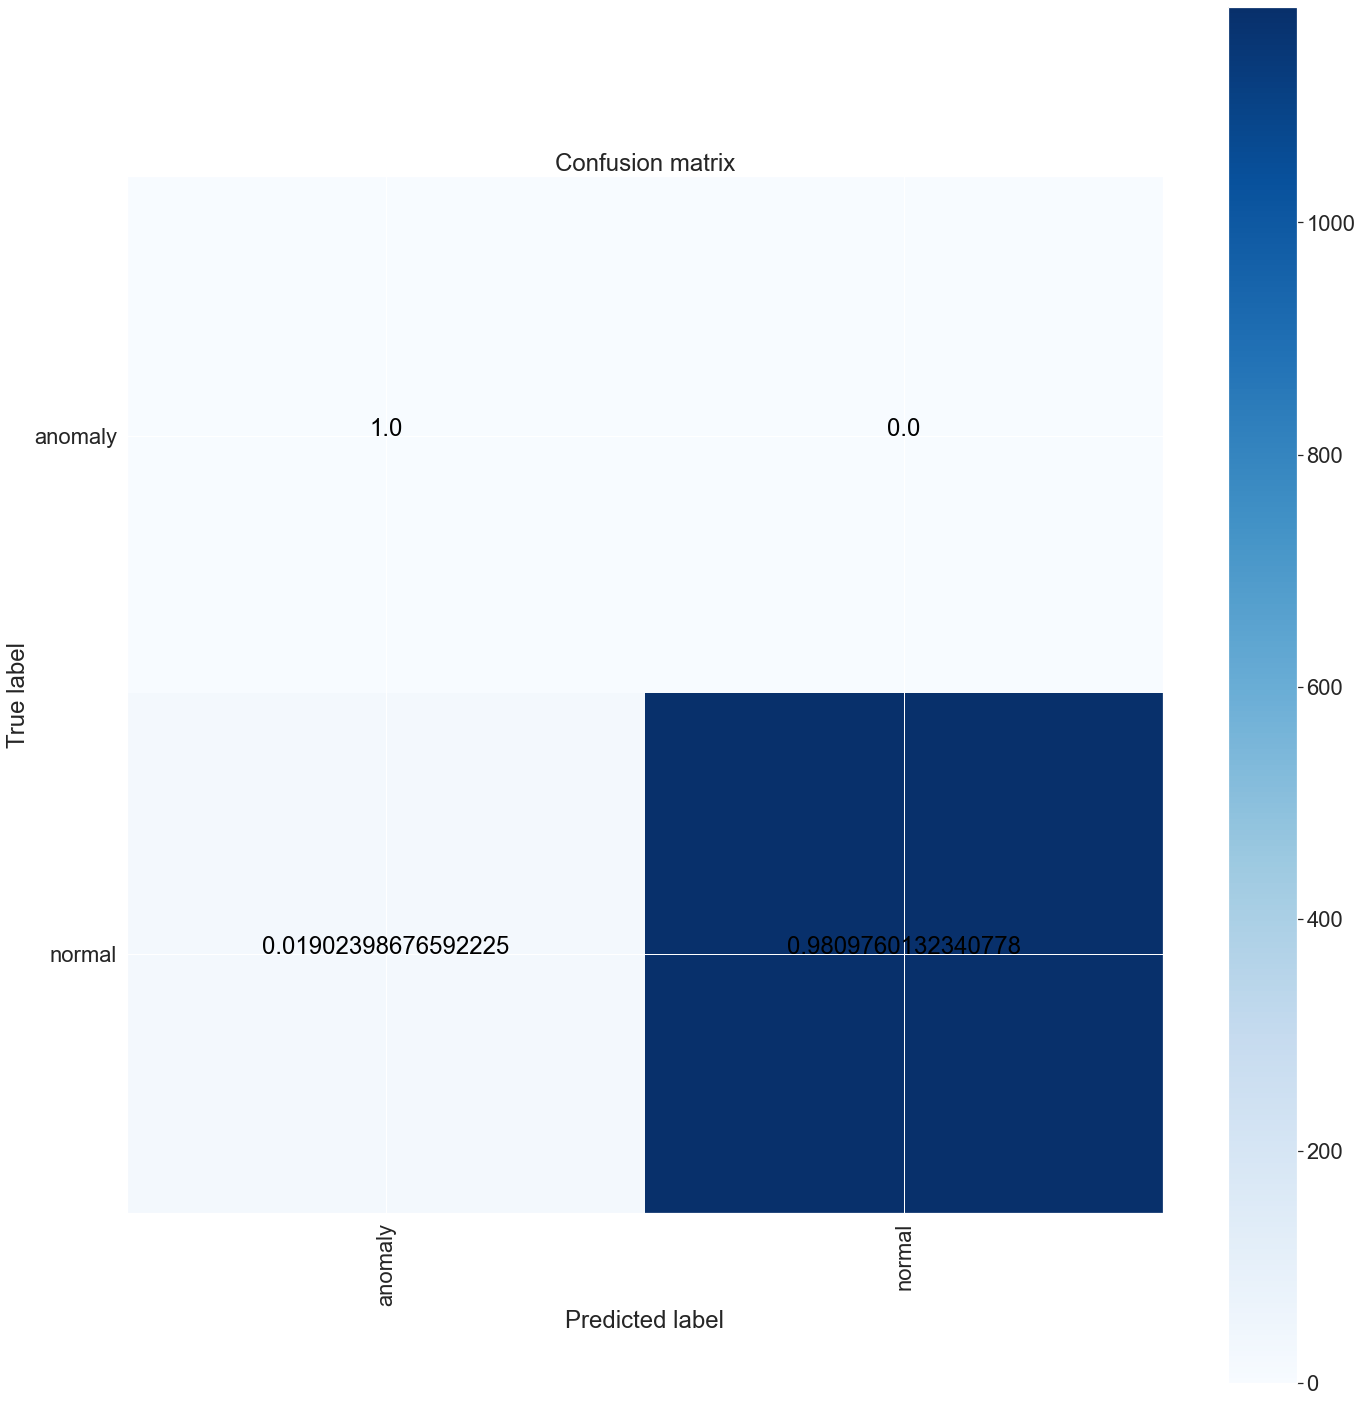

In [31]:
# Plotting the confusion matrix
confusion_mtx = confusion_matrix(comparison_cpu_utilization_label, normal_anomaly_predictions) 
plt.figure(figsize=(20,20))
sns.set(font_scale=2.0)
plot_confusion_matrix(confusion_mtx, classes = ['anomaly', 'normal'])

# LSTM Model #1

In [32]:
# Reshaping.
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [33]:
# LSTM model #1 with the loss as 'Mean Absolute Error'.
model = Sequential()
model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=196, return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(predict))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])

In [34]:
# Fitting the model on the training data.
history = model.fit(x_train, y_train, epochs=50, batch_size=16, verbose=1, validation_data=(x_test, y_test))

Epoch 1/50
176/176 [==============================] - 1s 7ms/step - loss: 0.1344 - accuracy: 0.1899 - val_loss: 0.0508 - val_accuracy: 0.2040
Epoch 2/50
176/176 [==============================] - 1s 5ms/step - loss: 0.1247 - accuracy: 0.2216 - val_loss: 0.0493 - val_accuracy: 0.2023
Epoch 3/50
176/176 [==============================] - 1s 5ms/step - loss: 0.1094 - accuracy: 0.4018 - val_loss: 0.0525 - val_accuracy: 0.1940
Epoch 4/50
176/176 [==============================] - 1s 5ms/step - loss: 0.0912 - accuracy: 0.5437 - val_loss: 0.0489 - val_accuracy: 0.2280
Epoch 5/50
176/176 [==============================] - 1s 5ms/step - loss: 0.0884 - accuracy: 0.5814 - val_loss: 0.0510 - val_accuracy: 0.2421
Epoch 6/50
176/176 [==============================] - 1s 5ms/step - loss: 0.0863 - accuracy: 0.6191 - val_loss: 0.0689 - val_accuracy: 0.2446
Epoch 7/50
176/176 [==============================] - 1s 5ms/step - loss: 0.0858 - accuracy: 0.6255 - val_loss: 0.0591 - val_accuracy: 0.2836
Epoch 

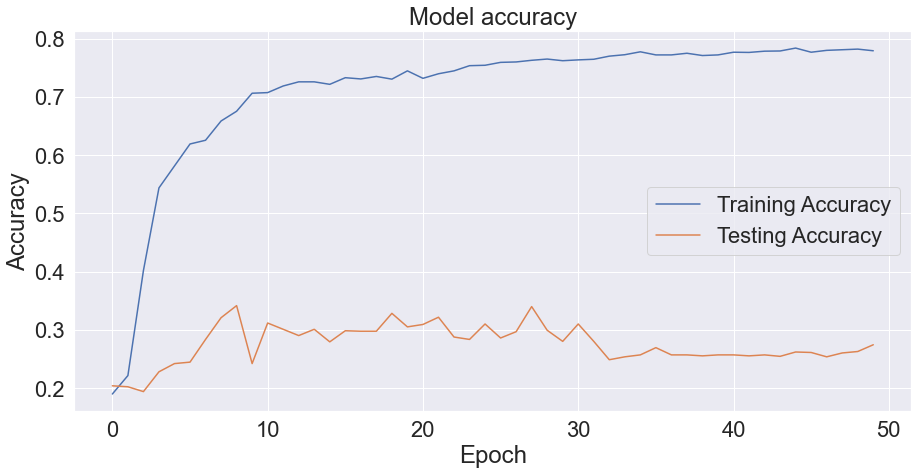

In [35]:
# Plot Accuracy.
plt.figure(figsize=(15, 7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='best')
plt.show()

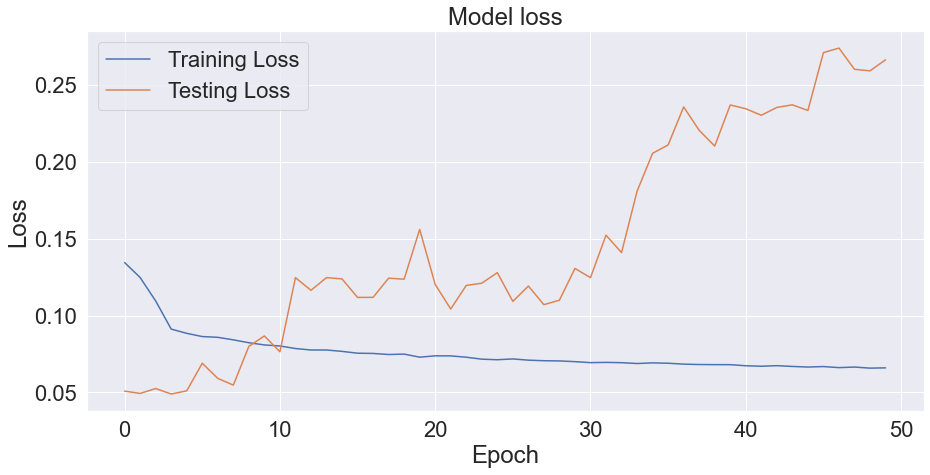

In [36]:
# Plot Loss.
plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Testing Loss'], loc='best')
plt.show()

In [37]:
# Making the predictions.
predictions = (model.predict(x_test))
predictions = scaler.inverse_transform(predictions)

print('Predictions Shape:', predictions.shape)
print('\nFirst 10 Predictions:\n', predictions[:10])
print('\nFirst 10 Actual Values:\n', scaler.inverse_transform(y_test[:10]))
print('\nLast 10 Predictions:\n', predictions[-10:])
print('\nLast 10 Actual Values:\n', scaler.inverse_transform(y_test[-10:]))

Predictions Shape: (1206, 5)

First 10 Predictions:
 [[45.018326 43.008053 43.83782  43.210533 41.885292]
 [41.874607 43.642166 43.100616 42.101    44.964157]
 [43.606182 42.703396 41.98877  45.514942 41.76825 ]
 [42.323135 41.792213 45.91307  42.334206 43.94171 ]
 [41.654625 45.596226 42.245323 44.91708  41.432552]
 [44.215214 43.107716 44.30185  42.042534 42.16064 ]
 [42.3322   43.851707 42.262768 42.451393 43.02442 ]
 [42.849625 42.87551  42.407574 43.133595 42.986748]
 [43.44145  42.986866 42.951668 44.077007 43.450233]
 [42.25872  43.340527 43.885242 44.449642 41.3403  ]]

First 10 Actual Values:
 [[46.384 43.716 43.996 42.432 42.512]
 [43.716 43.996 42.432 42.512 44.108]
 [43.996 42.432 42.512 44.108 45.422]
 [42.432 42.512 44.108 45.422 43.616]
 [42.512 44.108 45.422 43.616 42.984]
 [44.108 45.422 43.616 42.984 40.212]
 [45.422 43.616 42.984 40.212 47.16 ]
 [43.616 42.984 40.212 47.16  43.568]
 [42.984 40.212 47.16  43.568 43.24 ]
 [40.212 47.16  43.568 43.24  42.868]]

Last 10 

In [38]:
# Getting the average value for all the predictions.
average_predictions = [predictions[0][0], (predictions[0][1] + predictions[1][0]) / 2,
                       (predictions[0][2] + predictions[1][1] + predictions[2][0]) / 3,
                       (predictions[0][3] + predictions[1][2] + predictions[2][1] + predictions[3][0]) / 4]

for i in range(len(predictions)-4):
    average_predictions.append((predictions[i][4] + predictions[i+1][3] + predictions[i+2][2] + predictions[i+3][1] + 
                                predictions[i+4][0])/5)

average_predictions.append((predictions[-1][1] + predictions[-2][2] + predictions[-3][3] + predictions[-4][4])/4)
average_predictions.append((predictions[-1][2] + predictions[-2][3] + predictions[-3][4])/3)
average_predictions.append((predictions[-1][3] + predictions[-2][4])/2)
average_predictions.append(predictions[-1][4])

print('\nAverage Predictions Length:', len(average_predictions))
# print('\nAverage Predictions:\n', average_predictions)


Average Predictions Length: 1210


In [39]:
# Calculating the errors. # Here we identify the anomalies using Absolute Error.

# Creating the comparison dataset.
comparison_cpu_utilization = cpu_utilization['value'].values[len(x_train) + window:]
print('Length of the comparison dataset:', len(comparison_cpu_utilization))

absolute_errors = []
for i in range(len(average_predictions)):
    absolute_errors.append(abs(comparison_cpu_utilization[i]-average_predictions[i]))
    
print('\nMaximum Absolute Error Value:', max(absolute_errors))
print('\nMinimum Absolute Error Value', min(absolute_errors))
print('\nMean Absolute Error Value:', np.mean(absolute_errors))
print('\nMedian Absolute Error Value:', np.median(absolute_errors))
print('\nStandard Deviation of Absolute Error Values:', np.std(absolute_errors))

# Calculating the threshold.
threshold = np.mean(absolute_errors) + 2 * np.std(absolute_errors)
print('\nThreshold:', threshold)

Length of the comparison dataset: 1210

Maximum Absolute Error Value: 23.777925292968746

Minimum Absolute Error Value 0.016662109374998124

Mean Absolute Error Value: 5.743604918265014

Median Absolute Error Value: 6.054056091308588

Standard Deviation of Absolute Error Values: 2.0054560854880816

Threshold: 9.754517089241176


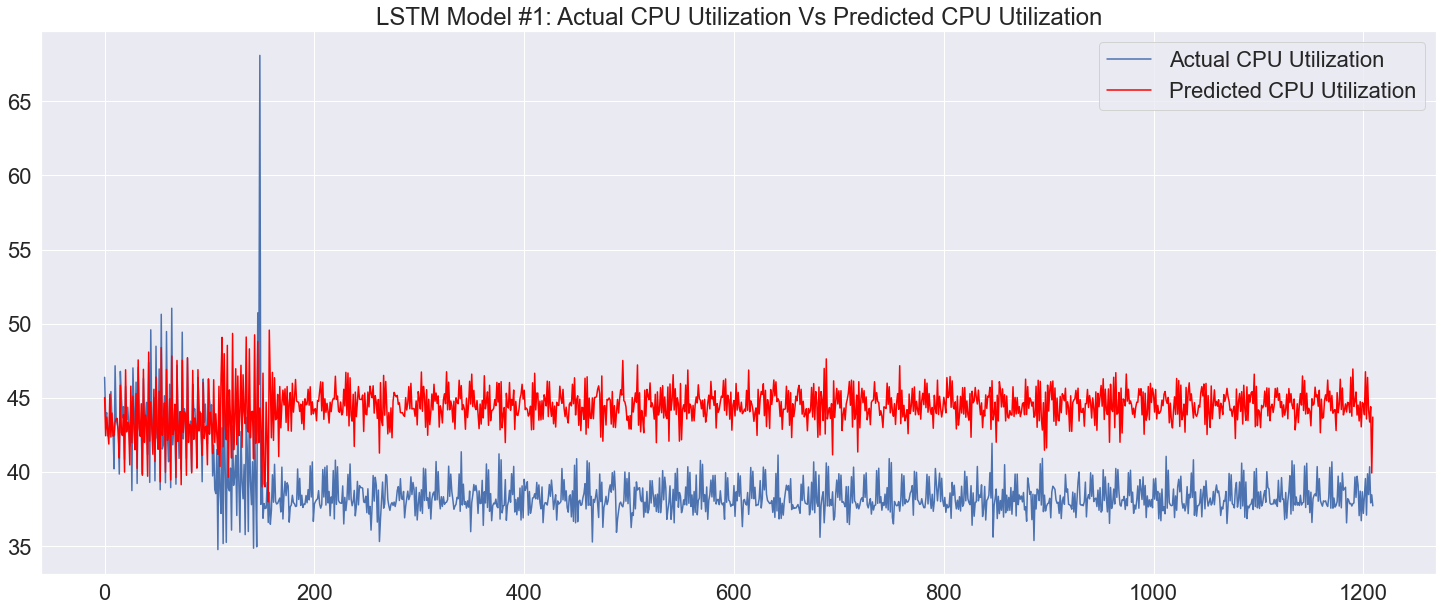

In [40]:
# Plotting the Actual CPU Utilization vs Predicted CPU Utilization.
plt.figure(figsize=(25, 10))
plt.plot(comparison_cpu_utilization, label='Actual CPU Utilization')
plt.plot(average_predictions, label='Predicted CPU Utilization', color='red')
plt.legend()
plt.title('LSTM Model #1: Actual CPU Utilization Vs Predicted CPU Utilization')
plt.show()

In [41]:
# Getting the anomaly indices.
anomalies = []
for absolute_error in absolute_errors:
    if absolute_error > threshold:
        anomalies.append(absolute_error)
        
print('Length of anomalies:', len(anomalies))

anomaly_indices = []
for anomaly in anomalies:
    anomaly_indices.append(absolute_errors.index(anomaly))
print('\nAnomaly Indices:', anomaly_indices)

Length of anomalies: 6

Anomaly Indices: [148, 151, 157, 494, 686, 758]


In [42]:
# Creating the anomalies dataset.
anomalies_dataset = []
for i in range(len(x_test) + predict - 1):
    if i in anomaly_indices:
        anomalies_dataset.append(comparison_cpu_utilization[i])
    else:
        anomalies_dataset.append(None)
        
# print((anomalies_dataset))

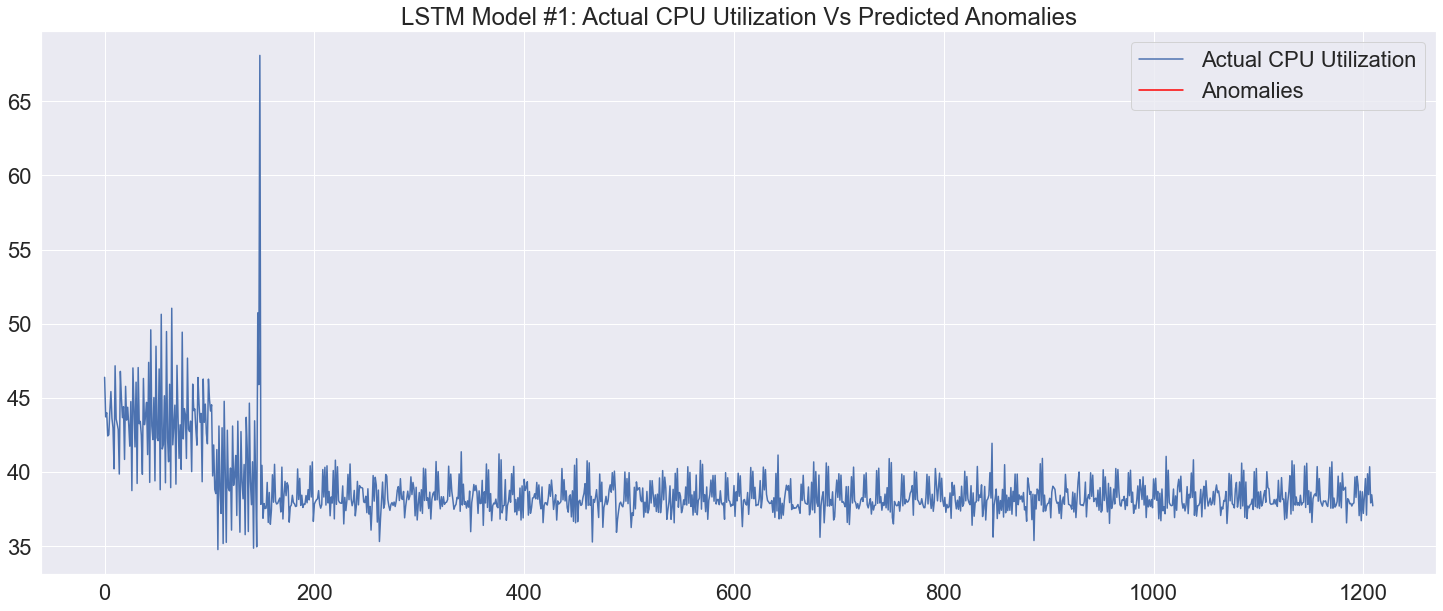

In [43]:
# Plotting Actual CPU Utilization vs Predicted CPU Utilization.
plt.figure(figsize=(25, 10))
plt.plot(comparison_cpu_utilization, label='Actual CPU Utilization')
plt.plot(anomalies_dataset, label='Anomalies', color='red')
plt.legend()
plt.title('LSTM Model #1: Actual CPU Utilization Vs Predicted Anomalies')
plt.show()

In [44]:
# Getting the predicted classes for plotting the confusion matrix.
normal_anomaly_predictions = []
for i in range(len(x_test) + predict - 1):
    if i in anomaly_indices:
        normal_anomaly_predictions.append('anomaly')
    else:
        normal_anomaly_predictions.append('normal')

# Getting the hypothesized classes for plotting the confusion matrix.
comparison_cpu_utilization_label = cpu_utilization['Label'].values[len(x_train) + window:]

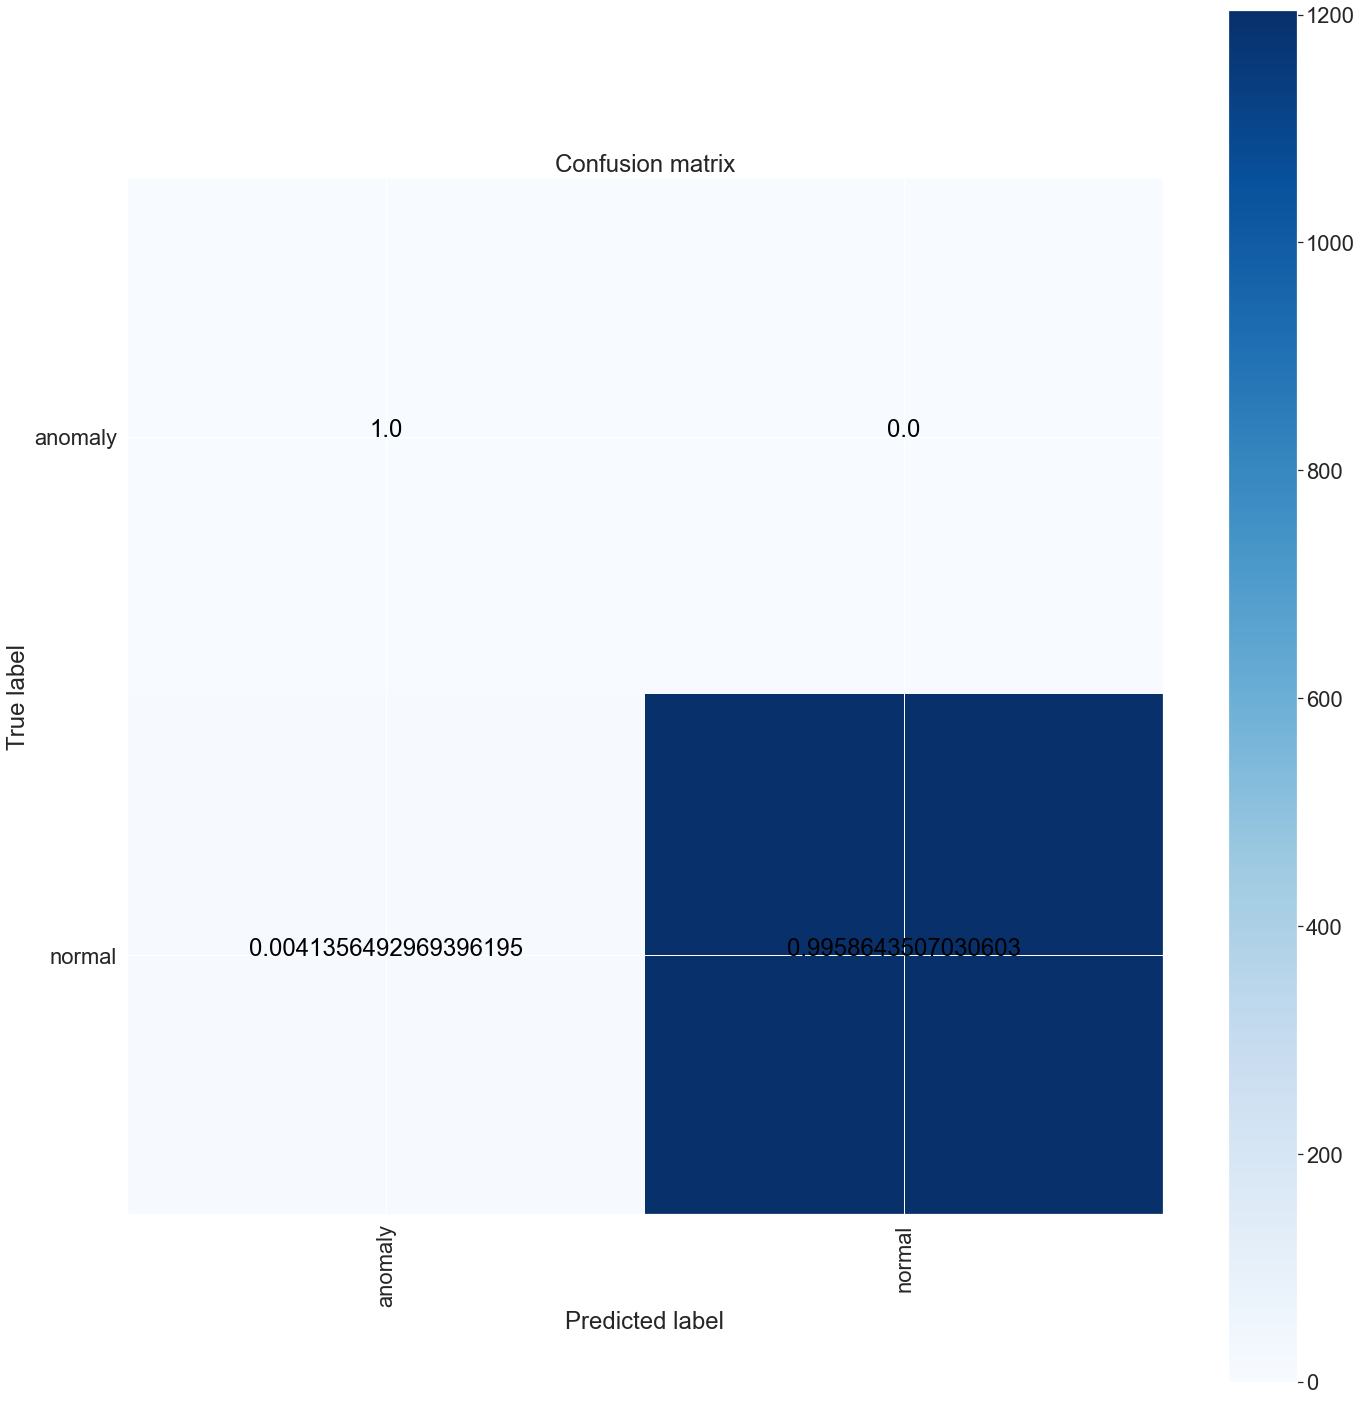

In [45]:
# Plotting the confusion matrix.
confusion_mtx = confusion_matrix(comparison_cpu_utilization_label, normal_anomaly_predictions) 
plt.figure(figsize=(20,20))
sns.set(font_scale=2.0)
plot_confusion_matrix(confusion_mtx, classes = ['anomaly', 'normal'])

# MLP Model #2

In [46]:
# Specifying the window and prediction parameters.
window = 144
predict = 5

In [47]:
# Creating the lists to store the data and the labels.
x = []
y = []
for i in range(window, len(normal_cpu_utilization) + 1):
    x.append(normal_cpu_utilization[i-window:i, 0])

for i in range(predict, len(normal_cpu_utilization) + 1):
    y.append(normal_cpu_utilization[i-predict:i, 0])
    
x = x[:-predict]
y = y[window:]

In [48]:
# Printing some statistics about the data.
print('Shape X:', len(x))
print('Shape Y:', len(y))
print('Maximum Data Value:', np.max(x))

Shape X: 3884
Shape Y: 3884
Maximum Data Value: 1.0


In [49]:
# Converting to array.
x = np.array(x)
y = np.array(y)

In [50]:
# Creating the train and test dataset.
x_train = x[:int(0.7 * len(x))]
y_train = y[:int(0.7 * len(y))]

x_test = x[int(0.7 * len(x)):]
y_test = y[int(0.7 * len(y)):]

In [51]:
# Printing some statistics about the data.
print('\nShape of the training dataset:', x_train.shape)
print('\n2 First two rows of the training data:\n', x_train[:2])
print('\n2 Last two rows of the training data:\n', x_train[-2:])

print('\nShape of the testing dataset:', x_test.shape)
print('\n2 First two rows of the testing data:\n', x_test[:2])
print('\n2 Last two rows of the testing data:\n', x_test[-2:])

print('\nShape of training data labels:', y_train.shape)
print('\n2 First two rows of the training data labels:\n', y_train[:2])
print('\n2 Last two rows of the training data labels:\n', y_train[-2:])

print('\nShape of testing data labels:', y_test.shape)
print('\n2 First two rows of the testing data labels:\n', y_test[:2])
print('\n2 Last two rows of the testing data labels:\n', y_test[-2:])


Shape of the training dataset: (2718, 144)

2 First two rows of the training data:
 [[0.78920617 0.45014324 0.29932539 0.63774143 0.55207467 0.47222992
  0.66269291 0.26356159 0.86119582 0.49135939 0.39044451 0.69097126
  0.53617965 0.41539599 0.59218187 0.27594492 0.76009611 0.53359209
  0.47287681 0.71425931 0.61593198 0.40560022 0.65077165 0.28537104
  0.82339895 0.50993439 0.3861011  0.73967286 0.53118935 0.38286665
  0.7370853  0.50974956 0.54449681 0.61713335 0.25247205 0.82432308
  0.45679697 0.37307088 0.67027077 0.56944829 0.49376213 0.56510489
  0.38942796 0.83975603 0.57508548 0.38711764 0.73431291 0.53257555
  0.48045467 0.60632104 0.32741891 0.85038351 0.45587284 0.39349413
  0.85140006 0.49671934 0.5759172  0.5379355  0.24729692 0.82108862
  0.49893725 0.42241937 0.61417614 0.49135939 0.49893725 0.8531559
  0.56399593 0.83402643 0.66056742 0.52924868 0.71583033 0.57268275
  0.48479808 0.66269291 0.27760835 0.81942519 0.48747805 0.32862028
  0.77118566 0.56076148 0.538027

In [52]:
# MLP Model #2 with the loss as 'Mean Squared Error'.
model = Sequential()
model.add(Dense(384, activity_regularizer=l1(0.0001)))
model.add(Dropout(0.2))
model.add(Dense(256, activity_regularizer=l1(0.0001)))
model.add(Dropout(0.2))
model.add(Dense(192, activity_regularizer=l1(0.0001)))
model.add(Dropout(0.2))
model.add(Dense(predict))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [53]:
# Fitting the MLP model on the training data.
history = model.fit(x_train, y_train, epochs=50, batch_size=4, verbose=1, validation_data=(x_test, y_test))

Epoch 1/50
680/680 [==============================] - 2s 2ms/step - loss: 0.0859 - accuracy: 0.3642 - val_loss: 0.0250 - val_accuracy: 0.3302
Epoch 2/50
680/680 [==============================] - 2s 2ms/step - loss: 0.0406 - accuracy: 0.4220 - val_loss: 0.0301 - val_accuracy: 0.2607
Epoch 3/50
680/680 [==============================] - 2s 2ms/step - loss: 0.0336 - accuracy: 0.4665 - val_loss: 0.0324 - val_accuracy: 0.3756
Epoch 4/50
680/680 [==============================] - 2s 2ms/step - loss: 0.0281 - accuracy: 0.5217 - val_loss: 0.0257 - val_accuracy: 0.2547
Epoch 5/50
680/680 [==============================] - 2s 2ms/step - loss: 0.0259 - accuracy: 0.5537 - val_loss: 0.0228 - val_accuracy: 0.4039
Epoch 6/50
680/680 [==============================] - 2s 2ms/step - loss: 0.0234 - accuracy: 0.5633 - val_loss: 0.0176 - val_accuracy: 0.4485
Epoch 7/50
680/680 [==============================] - 2s 2ms/step - loss: 0.0227 - accuracy: 0.5876 - val_loss: 0.0131 - val_accuracy: 0.3413
Epoch 

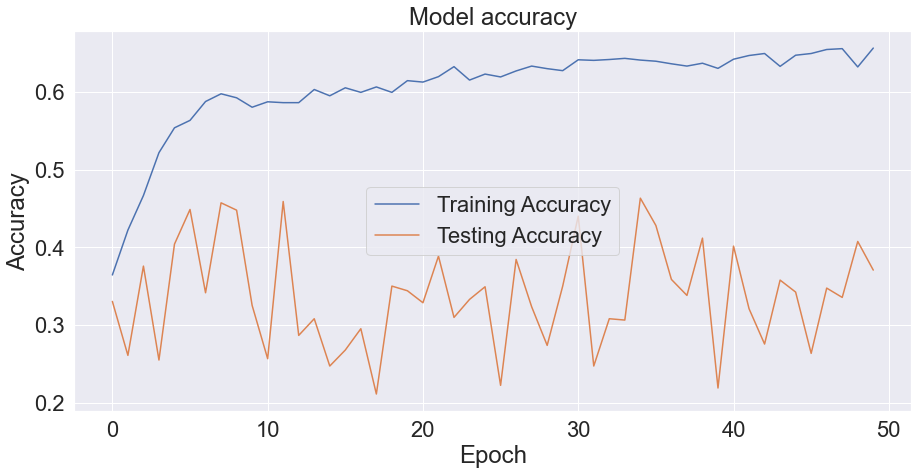

In [54]:
# Plot Accuracy.
plt.figure(figsize=(15, 7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='best')
plt.show()

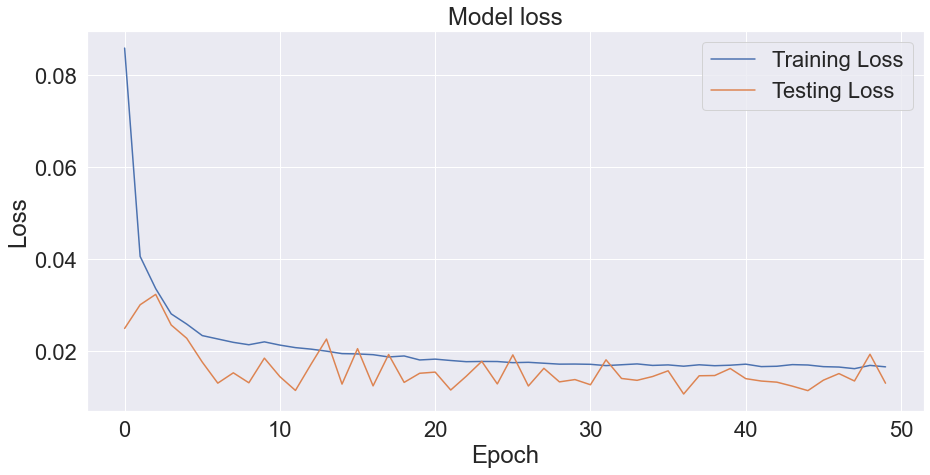

In [55]:
# Plot Loss.
plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Testing Loss'], loc='best')
plt.show()

In [56]:
# Making the predictions.
predictions = (model.predict(x_test))
predictions = scaler.inverse_transform(predictions)

print('Predictions Shape:', predictions.shape)
print('\nFirst 10 Predictions:\n', predictions[:10])
print('\nFirst 10 Actual Values:\n', scaler.inverse_transform(y_test[:10]))
print('\nLast 10 Predictions:\n', predictions[-10:])
print('\nLast 10 Actual Values:\n', scaler.inverse_transform(y_test[-10:]))

Predictions Shape: (1166, 5)

First 10 Predictions:
 [[45.775352 41.38735  47.089733 42.390034 43.605453]
 [42.497936 45.323875 42.72169  44.522717 43.360725]
 [46.802116 41.905167 44.88874  44.04265  41.143562]
 [42.79598  43.895615 44.572357 42.359337 44.713985]
 [45.943073 42.70178  42.60056  45.21405  40.57735 ]
 [43.09361  42.033035 45.701584 41.817574 45.682354]
 [42.62909  43.53053  42.01213  46.03021  42.423485]
 [45.286    40.77607  46.552464 42.849274 40.838375]
 [41.952583 46.725273 43.811142 42.539776 47.478447]
 [47.69919  41.724915 42.2987   47.340965 39.681343]]

First 10 Actual Values:
 [[44.694 41.174 47.39  39.298 49.586]
 [41.174 47.39  39.298 49.586 43.1  ]
 [47.39  39.298 49.586 43.1   42.184]
 [39.298 49.586 43.1   42.184 45.022]
 [49.586 43.1   42.184 45.022 39.4  ]
 [43.1   42.184 45.022 39.4   48.48 ]
 [42.184 45.022 39.4   48.48  42.308]
 [45.022 39.4   48.48  42.308 42.112]
 [39.4   48.48  42.308 42.112 46.948]
 [48.48  42.308 42.112 46.948 38.802]]

Last 10 

In [57]:
# Getting the average value for all the predictions.
average_predictions = [predictions[0][0], (predictions[0][1] + predictions[1][0]) / 2,
                       (predictions[0][2] + predictions[1][1] + predictions[2][0]) / 3,
                       (predictions[0][3] + predictions[1][2] + predictions[2][1] + predictions[3][0]) / 4]

for i in range(len(predictions) - 4):
    average_predictions.append((predictions[i][4] + predictions[i + 1][3] + predictions[i + 2][2] + predictions[i + 3][
        1] + predictions[i + 4][0]) / 5)

average_predictions.append((predictions[-1][1] + predictions[-2][2] + predictions[-3][3] + predictions[-4][4]) / 4)
average_predictions.append((predictions[-1][2] + predictions[-2][3] + predictions[-3][4]) / 3)
average_predictions.append((predictions[-1][3] + predictions[-2][4]) / 2)
average_predictions.append(predictions[-1][4])

print('\nAverage Predictions Length:', len(average_predictions))
# print('\nAverage Predictions:\n', average_predictions)


Average Predictions Length: 1170


In [58]:
# Calculating the errors. # Here we identify the anomalies using Squared Error.

# Creating the comparison dataset.
comparison_cpu_utilization = cpu_utilization['value'].values[len(x_train) + window:]

print('Length of the comparison dataset:', len(comparison_cpu_utilization))

squared_errors = []
for i in range(len(average_predictions)):
    squared_errors.append((comparison_cpu_utilization[i]-average_predictions[i]) ** 2)

# Printing some statistics about the errors.
print('\nMaximum Squared Error Value:', max(squared_errors))
print('\nMinimum Squared Error Value', min(squared_errors))
print('\nMean Squared Error Value:', np.mean(squared_errors))
print('\nMedian Squared Error Value:', np.median(squared_errors))
print('\nStandard Deviation of Squared Error Values:', np.std(squared_errors))

# Calculating the threshold.
threshold = np.mean(squared_errors) + 0.5 * np.std(squared_errors)
print('\nThreshold:', threshold)

Length of the comparison dataset: 1170

Maximum Squared Error Value: 759.576773184557

Minimum Squared Error Value 2.6259664445977323e-06

Mean Squared Error Value: 3.30354358331306

Median Squared Error Value: 1.475172911729639

Standard Deviation of Squared Error Values: 22.669848857438865

Threshold: 14.638468012032492


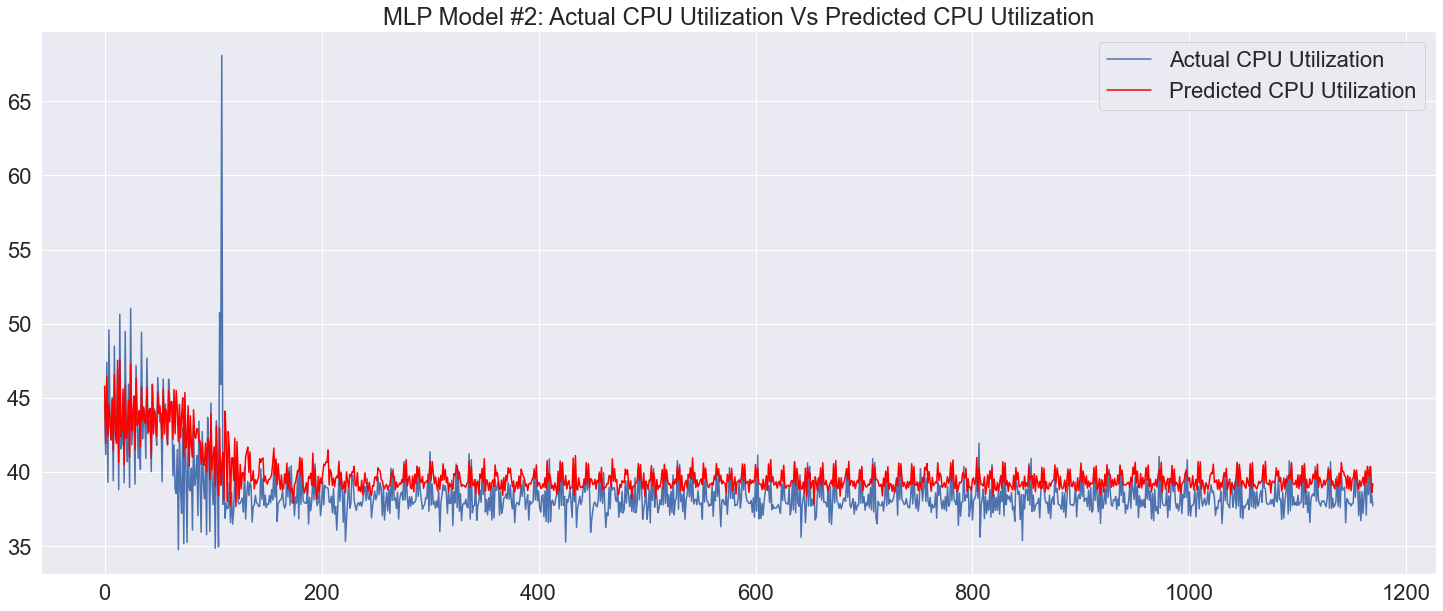

In [59]:
# Plotting Actual CPU Utilization vs Predicted CPU Utilization.
plt.figure(figsize=(25, 10))
plt.plot(comparison_cpu_utilization, label='Actual CPU Utilization')
plt.plot(average_predictions, label='Predicted CPU Utilization', color='red')
plt.legend()
plt.title('MLP Model #2: Actual CPU Utilization Vs Predicted CPU Utilization')
plt.show()

In [60]:
# Getting the anomaly indices.
anomalies = []
for squared_error in squared_errors:
    if squared_error > threshold:
        anomalies.append(squared_error)
        
print('Length of anomalies:', len(anomalies))

anomaly_indices = []
for anomaly in anomalies:
    anomaly_indices.append(squared_errors.index(anomaly))
print('\nAnomaly Indices:', anomaly_indices)

Length of anomalies: 23

Anomaly Indices: [4, 66, 68, 71, 73, 76, 79, 81, 86, 89, 94, 102, 106, 107, 108, 111, 112, 114, 118, 130, 425, 807, 846]


In [61]:
# Creating the anomalies dataset.
anomalies_dataset = []
for i in range(len(x_test) + predict - 1):
    if i in anomaly_indices:
        anomalies_dataset.append(comparison_cpu_utilization[i])
    else:
        anomalies_dataset.append(None)
        
# print((anomalies_dataset))

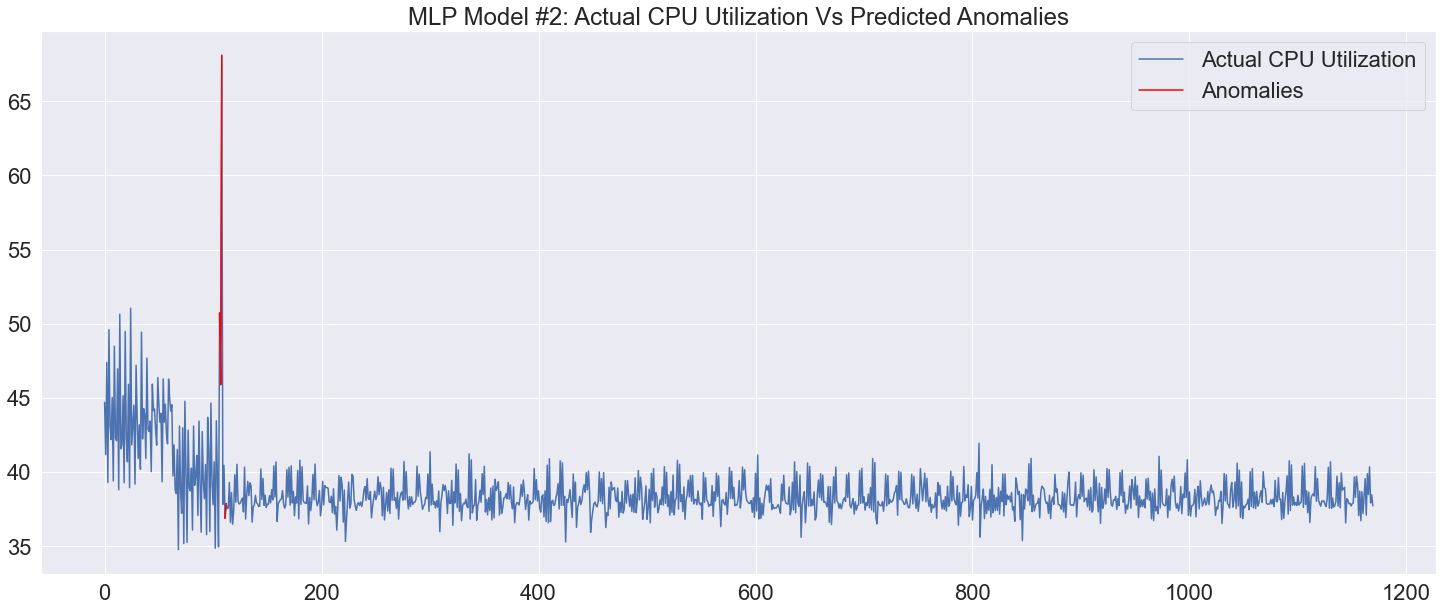

In [62]:
# Plotting Actual CPU Utilization vs Predicted CPU Utilization.
plt.figure(figsize=(25, 10))
plt.plot(comparison_cpu_utilization, label='Actual CPU Utilization')
plt.plot(anomalies_dataset, label='Anomalies', color='red')
plt.legend()
plt.title('MLP Model #2: Actual CPU Utilization Vs Predicted Anomalies')
plt.show()

In [63]:
# Getting the predicted classes for plotting the confusion matrix.
normal_anomaly_predictions = []
for i in range(len(x_test) + predict - 1):
    if i in anomaly_indices:
        normal_anomaly_predictions.append('anomaly')
    else:
        normal_anomaly_predictions.append('normal')

# Getting the hypothesized classes for plotting the confusion matrix.
comparison_cpu_utilization_label = cpu_utilization['Label'].values[len(x_train) + window:]

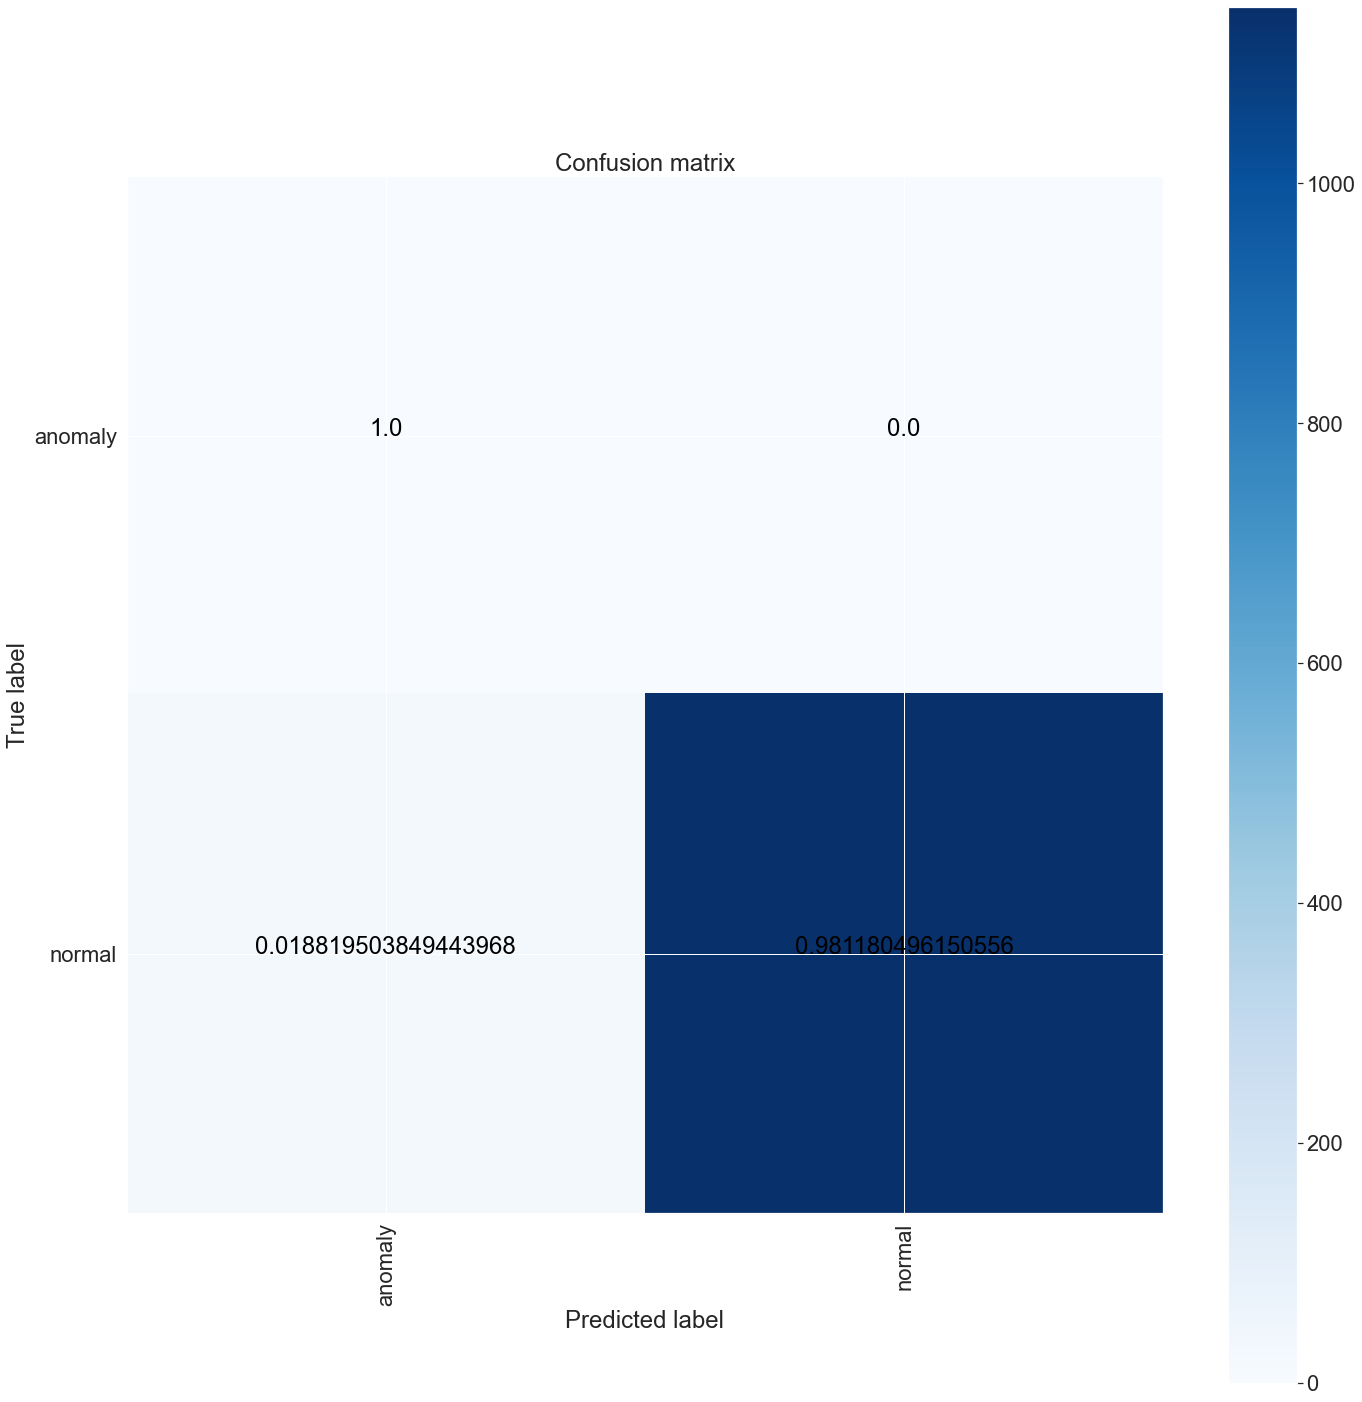

In [64]:
# Plotting the confusion matrix
confusion_mtx = confusion_matrix(comparison_cpu_utilization_label, normal_anomaly_predictions)
plt.figure(figsize=(20, 20))
sns.set(font_scale=2.0)
plot_confusion_matrix(confusion_mtx, classes=['anomaly', 'normal'])

# LSTM Model #2

In [65]:
# Reshaping.
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [66]:
# LSTM Model #2 with the loss as 'Mean Squared Error'.
model = Sequential()
model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=192, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(predict))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [67]:
# Fitting the model on the training data.
history = model.fit(x_train, y_train, epochs=20, batch_size=128, verbose=1, validation_data=(x_test, y_test))

Epoch 1/20
22/22 [==============================] - 3s 118ms/step - loss: 0.1132 - accuracy: 0.1968 - val_loss: 0.0283 - val_accuracy: 0.2110
Epoch 2/20
22/22 [==============================] - 2s 94ms/step - loss: 0.0263 - accuracy: 0.2042 - val_loss: 0.0177 - val_accuracy: 0.2075
Epoch 3/20
22/22 [==============================] - 2s 95ms/step - loss: 0.0241 - accuracy: 0.1880 - val_loss: 0.0131 - val_accuracy: 0.2136
Epoch 4/20
22/22 [==============================] - 2s 95ms/step - loss: 0.0238 - accuracy: 0.1902 - val_loss: 0.0112 - val_accuracy: 0.2127
Epoch 5/20
22/22 [==============================] - 2s 97ms/step - loss: 0.0236 - accuracy: 0.1836 - val_loss: 0.0097 - val_accuracy: 0.2093
Epoch 6/20
22/22 [==============================] - 2s 94ms/step - loss: 0.0235 - accuracy: 0.1880 - val_loss: 0.0078 - val_accuracy: 0.2118
Epoch 7/20
22/22 [==============================] - 2s 94ms/step - loss: 0.0235 - accuracy: 0.1876 - val_loss: 0.0063 - val_accuracy: 0.2093
Epoch 8/20
2

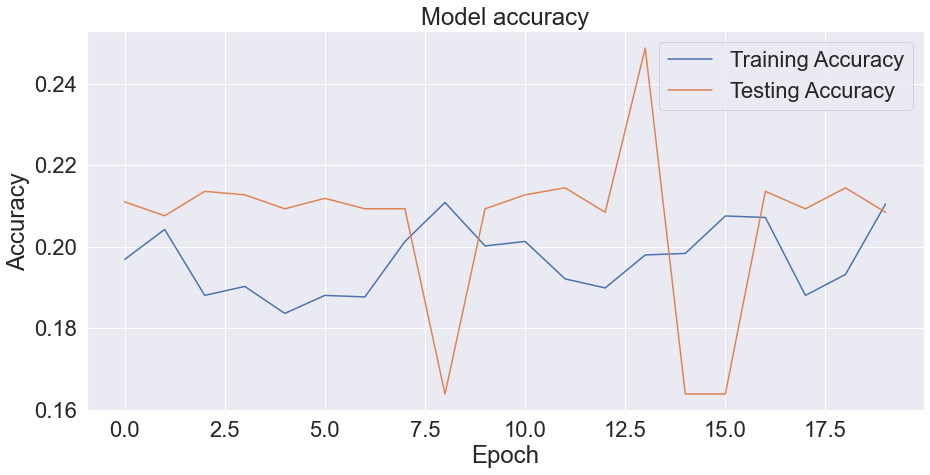

In [68]:
# Plot Accuracy.
plt.figure(figsize=(15, 7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='best')
plt.show()

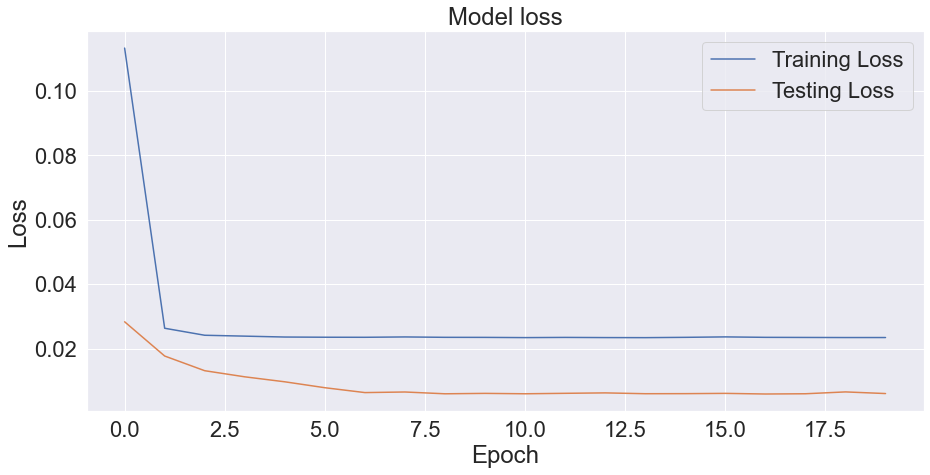

In [69]:
# Plot Loss.
plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Testing Loss'], loc='best')
plt.show()

In [70]:
# Making the predictions.
predictions = (model.predict(x_test))
predictions = scaler.inverse_transform(predictions)

print('Predictions Shape:', predictions.shape)
print('\nFirst 10 Predictions:\n', predictions[:10])
print('\nFirst 10 Actual Values:\n', scaler.inverse_transform(y_test[:10]))
print('\nLast 10 Predictions:\n', predictions[-10:])
print('\nLast 10 Actual Values:\n', scaler.inverse_transform(y_test[-10:]))

Predictions Shape: (1166, 5)

First 10 Predictions:
 [[43.447083 44.0013   43.331207 43.93807  43.685097]
 [43.397366 43.97766  43.297665 43.88958  43.664467]
 [43.469173 44.00175  43.337685 43.951195 43.685974]
 [43.385235 43.958645 43.28377  43.86643  43.64776 ]
 [43.379875 43.953506 43.28286  43.86654  43.644756]
 [43.395214 43.95653  43.296932 43.881584 43.654892]
 [43.385155 43.953094 43.294216 43.877403 43.65528 ]
 [43.453575 43.98069  43.335907 43.93898  43.681396]
 [43.380104 43.950146 43.29124  43.865685 43.651287]
 [43.40792  43.968315 43.309277 43.893394 43.659637]]

First 10 Actual Values:
 [[44.694 41.174 47.39  39.298 49.586]
 [41.174 47.39  39.298 49.586 43.1  ]
 [47.39  39.298 49.586 43.1   42.184]
 [39.298 49.586 43.1   42.184 45.022]
 [49.586 43.1   42.184 45.022 39.4  ]
 [43.1   42.184 45.022 39.4   48.48 ]
 [42.184 45.022 39.4   48.48  42.308]
 [45.022 39.4   48.48  42.308 42.112]
 [39.4   48.48  42.308 42.112 46.948]
 [48.48  42.308 42.112 46.948 38.802]]

Last 10 

In [71]:
# Getting the average value for all the predictions.
average_predictions = [predictions[0][0], (predictions[0][1] + predictions[1][0]) / 2,
                       (predictions[0][2] + predictions[1][1] + predictions[2][0]) / 3,
                       (predictions[0][3] + predictions[1][2] + predictions[2][1] + predictions[3][0]) / 4]

for i in range(len(predictions) - 4):
    average_predictions.append((predictions[i][4] + predictions[i + 1][3] + predictions[i + 2][2] + predictions[i + 3][
        1] + predictions[i + 4][0]) / 5)

average_predictions.append((predictions[-1][1] + predictions[-2][2] + predictions[-3][3] + predictions[-4][4]) / 4)
average_predictions.append((predictions[-1][2] + predictions[-2][3] + predictions[-3][4]) / 3)
average_predictions.append((predictions[-1][3] + predictions[-2][4]) / 2)
average_predictions.append(predictions[-1][4])

print('\nAverage Predictions Length:', len(average_predictions))
# print('\nAverage Predictions:\n', average_predictions)


Average Predictions Length: 1170


In [72]:
# Calculating the errors. # Here we identify the anomalies using Squared Error.

# Creating the comparison dataset.
comparison_cpu_utilization = cpu_utilization['value'].values[len(x_train) + window:]
print('Length of the comparison dataset:', len(comparison_cpu_utilization))

squared_errors = []
for i in range(len(average_predictions)):
    squared_errors.append((comparison_cpu_utilization[i]-average_predictions[i]) ** 2)
    
print('\nMaximum Squared Error Value:', max(squared_errors))
print('\nMinimum Squared Error Value', min(squared_errors))
print('\nMean Squared Error Value:', np.mean(squared_errors))
print('\nMedian Squared Error Value:', np.median(squared_errors))
print('\nStandard Deviation of Squared Error Values:', np.std(squared_errors))

# Calculating the threshold.
threshold = np.mean(squared_errors) + np.std(squared_errors)
print('\nThreshold:', threshold)

Length of the comparison dataset: 1170

Maximum Squared Error Value: 658.262512875645

Minimum Squared Error Value 2.760353088383685e-07

Mean Squared Error Value: 3.367749067458617

Median Squared Error Value: 0.4755630749421173

Standard Deviation of Squared Error Values: 20.56846235781078

Threshold: 23.9362114252694


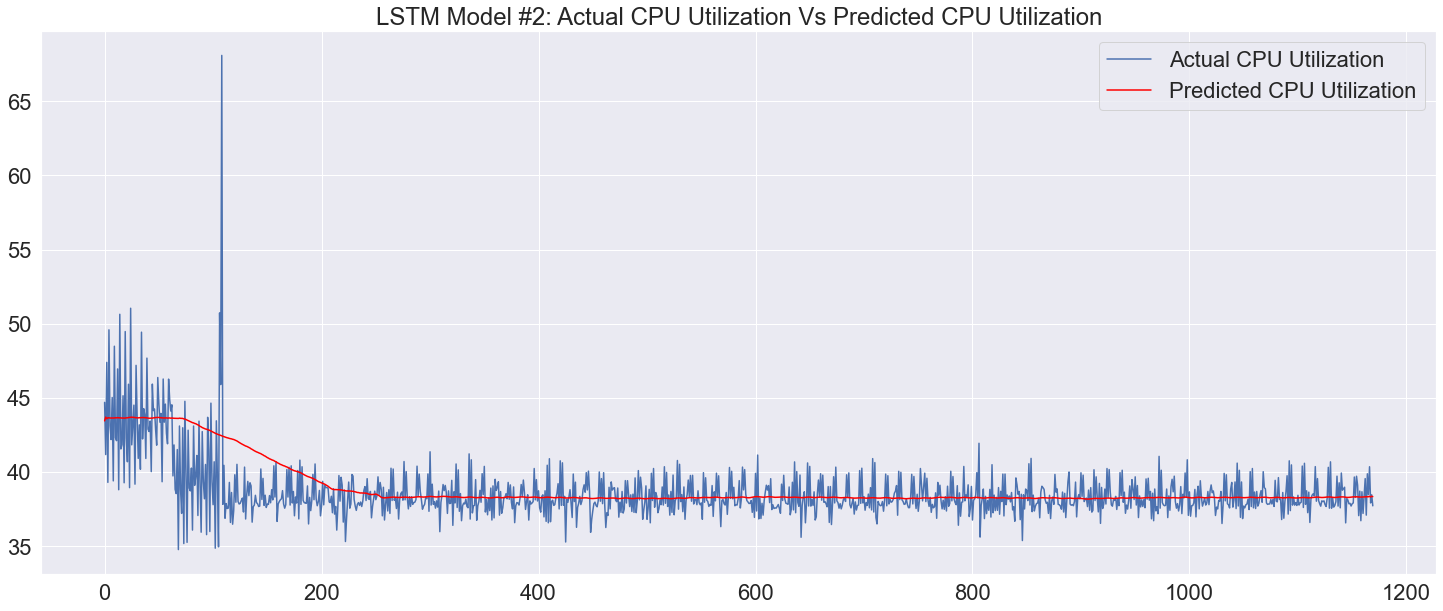

In [73]:
# Plotting Actual CPU Utilization vs Predicted CPU Utilization.
plt.figure(figsize=(25, 10))
plt.plot(comparison_cpu_utilization, label='Actual CPU Utilization')
plt.plot(average_predictions, label='Predicted CPU Utilization', color='red')
plt.legend()
plt.title('LSTM Model #2: Actual CPU Utilization Vs Predicted CPU Utilization')
plt.show()

In [74]:
# Getting the anomaly indices.
anomalies = []
for squared_error in squared_errors:
    if squared_error > threshold:
        anomalies.append(squared_error)
        
print('Length of anomalies:', len(anomalies))

anomaly_indices = []
for anomaly in anomalies:
    anomaly_indices.append(squared_errors.index(anomaly))
print('\nAnomaly Indices:', anomaly_indices)

Length of anomalies: 24

Anomaly Indices: [4, 14, 19, 24, 34, 66, 68, 71, 73, 76, 81, 86, 89, 94, 97, 102, 105, 106, 108, 111, 116, 118, 130, 136]


In [75]:
# Creating the anomalies dataset.
anomalies_dataset = []
for i in range(len(x_test) + predict - 1):
    if i in anomaly_indices:
        anomalies_dataset.append(comparison_cpu_utilization[i])
    else:
        anomalies_dataset.append(None)
        
# print((anomalies_dataset))

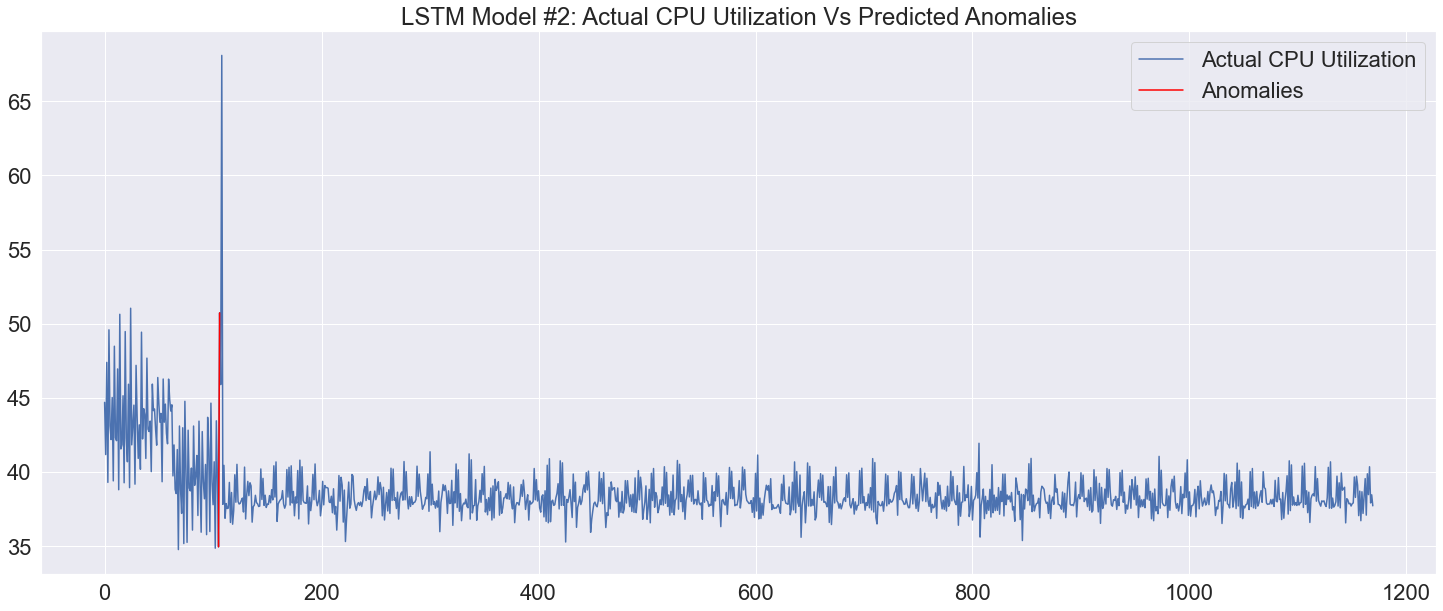

In [76]:
# Plotting Actual CPU Utilization vs Predicted Anomalies.
plt.figure(figsize=(25, 10))
plt.plot(comparison_cpu_utilization, label='Actual CPU Utilization')
plt.plot(anomalies_dataset, label='Anomalies', color='red')
plt.legend()
plt.title('LSTM Model #2: Actual CPU Utilization Vs Predicted Anomalies')
plt.show()

In [77]:
# Getting the predicted classes for plotting the confusion matrix.
normal_anomaly_predictions = []
for i in range(len(x_test) + predict - 1):
    if i in anomaly_indices:
        normal_anomaly_predictions.append('anomaly')
    else:
        normal_anomaly_predictions.append('normal')

# Getting the hypothesized classes for plotting the confusion matrix.
comparison_cpu_utilization_label = cpu_utilization['Label'].values[len(x_train) + window:]

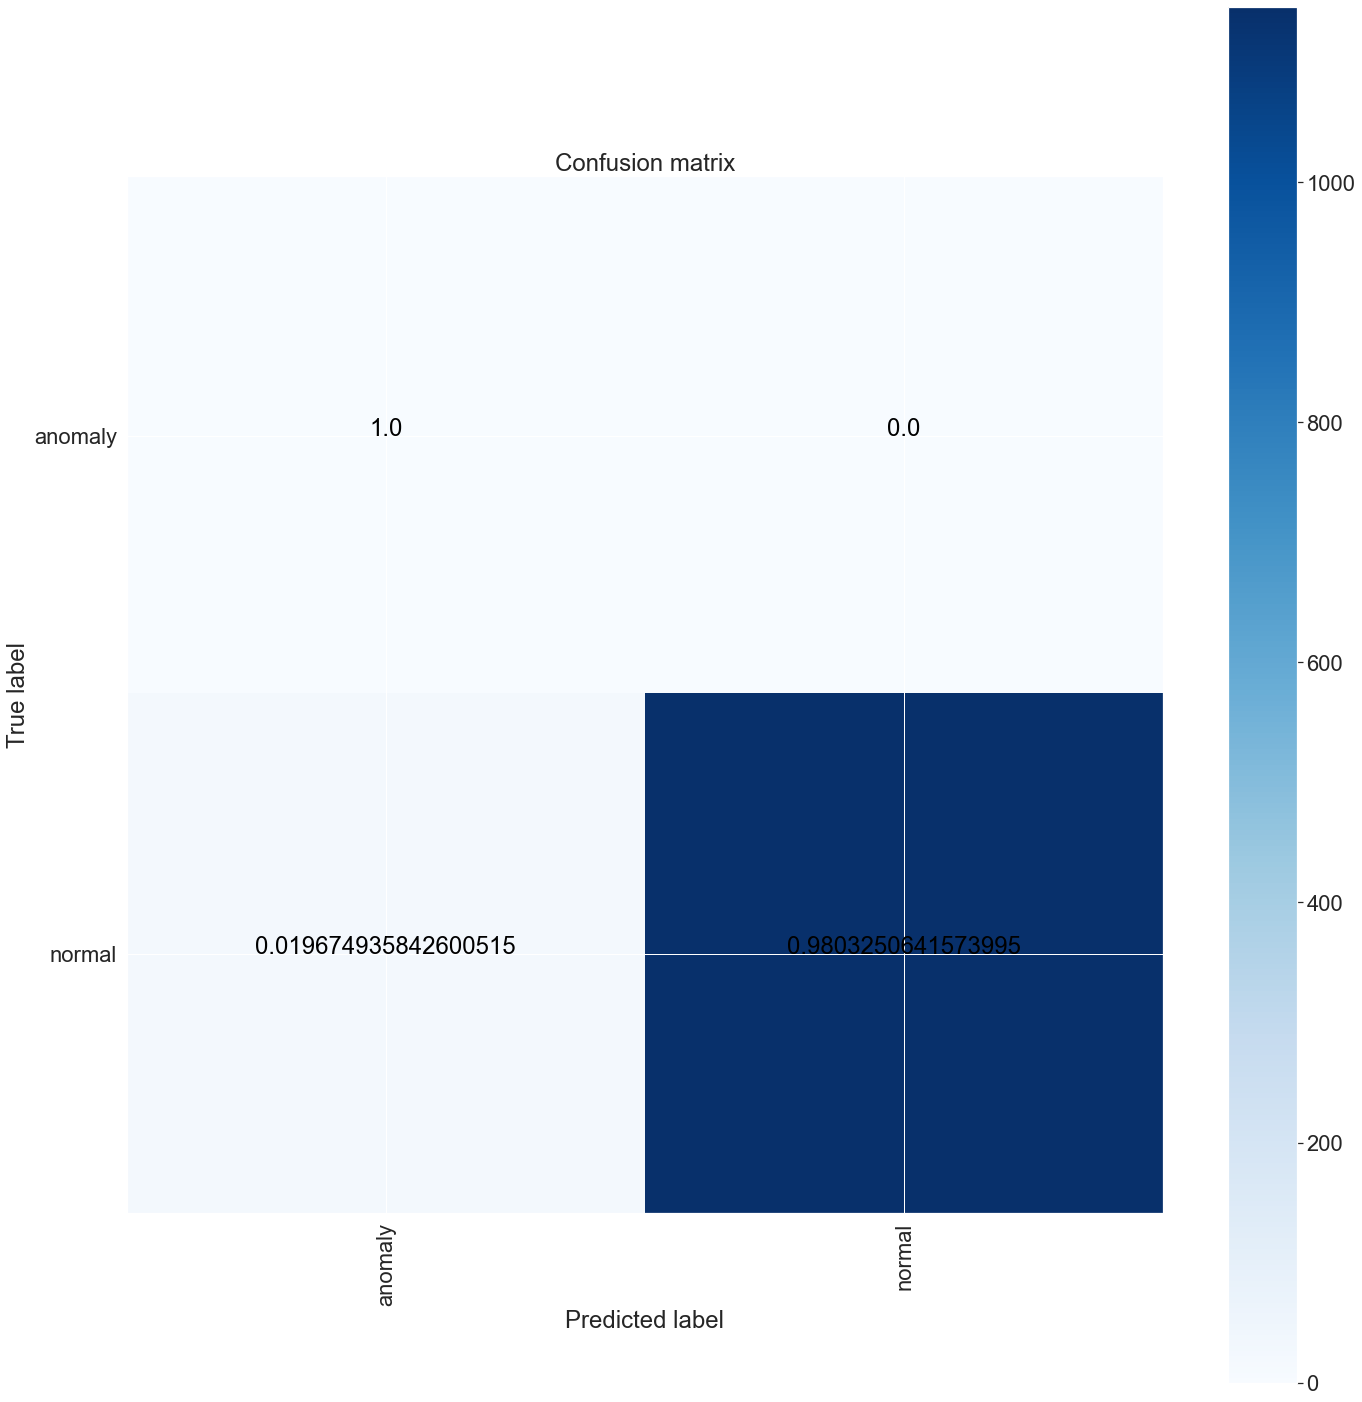

In [78]:
# Plotting the confusion matrix
confusion_mtx = confusion_matrix(comparison_cpu_utilization_label, normal_anomaly_predictions)
plt.figure(figsize=(20, 20))
sns.set(font_scale=2.0)
plot_confusion_matrix(confusion_mtx, classes=['anomaly', 'normal'])

# MLP Model #3

In [79]:
# Specifying the window and prediction parameters.
window = 288
predict = 5

In [80]:
# Creating the lists to store the data and the labels.
x = []
y = []
for i in range(window, len(normal_cpu_utilization) + 1):
    x.append(normal_cpu_utilization[i-window:i, 0])

for i in range(predict, len(normal_cpu_utilization) + 1):
    y.append(normal_cpu_utilization[i-predict:i, 0])
    
x = x[:-predict]
y = y[window:]

In [81]:
# Printing some statistics about the data.
print('Shape X:', len(x))
print('Shape Y:', len(y))
print('Maximum Data Value:', np.max(x))

Shape X: 3740
Shape Y: 3740
Maximum Data Value: 1.0


In [82]:
# Converting to array.
x = np.array(x)
y = np.array(y)

In [83]:
# Creating the train and test dataset.
x_train = x[:int(0.7 * len(x))]
y_train = y[:int(0.7 * len(y))]

x_test = x[int(0.7 * len(x)):]
y_test = y[int(0.7 * len(y)):]

In [84]:
# Printing some statistics about the data.
print('\nShape of the training dataset:', x_train.shape)
print('\n2 First two rows of the training data:\n', x_train[:2])
print('\n2 Last two rows of the training data:\n', x_train[-2:])

print('\nShape of the testing dataset:', x_test.shape)
print('\n2 First two rows of the testing data:\n', x_test[:2])
print('\n2 Last two rows of the testing data:\n', x_test[-2:])

print('\nShape of training data labels:', y_train.shape)
print('\n2 First two rows of the training data labels:\n', y_train[:2])
print('\n2 Last two rows of the training data labels:\n', y_train[-2:])

print('\nShape of testing data labels:', y_test.shape)
print('\n2 First two rows of the testing data labels:\n', y_test[:2])
print('\n2 Last two rows of the testing data labels:\n', y_test[-2:])


Shape of the training dataset: (2618, 288)

2 First two rows of the training data:
 [[0.78920617 0.45014324 0.29932539 0.63774143 0.55207467 0.47222992
  0.66269291 0.26356159 0.86119582 0.49135939 0.39044451 0.69097126
  0.53617965 0.41539599 0.59218187 0.27594492 0.76009611 0.53359209
  0.47287681 0.71425931 0.61593198 0.40560022 0.65077165 0.28537104
  0.82339895 0.50993439 0.3861011  0.73967286 0.53118935 0.38286665
  0.7370853  0.50974956 0.54449681 0.61713335 0.25247205 0.82432308
  0.45679697 0.37307088 0.67027077 0.56944829 0.49376213 0.56510489
  0.38942796 0.83975603 0.57508548 0.38711764 0.73431291 0.53257555
  0.48045467 0.60632104 0.32741891 0.85038351 0.45587284 0.39349413
  0.85140006 0.49671934 0.5759172  0.5379355  0.24729692 0.82108862
  0.49893725 0.42241937 0.61417614 0.49135939 0.49893725 0.8531559
  0.56399593 0.83402643 0.66056742 0.52924868 0.71583033 0.57268275
  0.48479808 0.66269291 0.27760835 0.81942519 0.48747805 0.32862028
  0.77118566 0.56076148 0.538027

In [85]:
# MLP Model #3 with the loss as 'Mean Absolute Percentage Error'.
model = Sequential()
model.add(Dense(256, activity_regularizer=l1_l2(0.000001)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(196, activity_regularizer=l1_l2(0.000001)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(128, activity_regularizer=l1_l2(0.000001)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(predict))

model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['accuracy'])

In [86]:
# Fitting the MLP model on the training data.
history = model.fit(x_train, y_train, epochs=50, batch_size=16, verbose=1, validation_data=(x_test, y_test))

Epoch 1/50
164/164 [==============================] - 1s 4ms/step - loss: 162.6762 - accuracy: 0.2162 - val_loss: 321018.2188 - val_accuracy: 0.2201
Epoch 2/50
164/164 [==============================] - 1s 4ms/step - loss: 103.9325 - accuracy: 0.2086 - val_loss: 342985.8438 - val_accuracy: 0.1622
Epoch 3/50
164/164 [==============================] - 1s 4ms/step - loss: 78.7943 - accuracy: 0.2277 - val_loss: 259763.1719 - val_accuracy: 0.2210
Epoch 4/50
164/164 [==============================] - 1s 4ms/step - loss: 62.3046 - accuracy: 0.2433 - val_loss: 267704.3438 - val_accuracy: 0.2201
Epoch 5/50
164/164 [==============================] - 1s 4ms/step - loss: 49.4520 - accuracy: 0.2823 - val_loss: 281570.6875 - val_accuracy: 0.2068
Epoch 6/50
164/164 [==============================] - 1s 4ms/step - loss: 40.1414 - accuracy: 0.3228 - val_loss: 277684.4062 - val_accuracy: 0.1765
Epoch 7/50
164/164 [==============================] - 1s 4ms/step - loss: 34.2423 - accuracy: 0.3770 - val_los

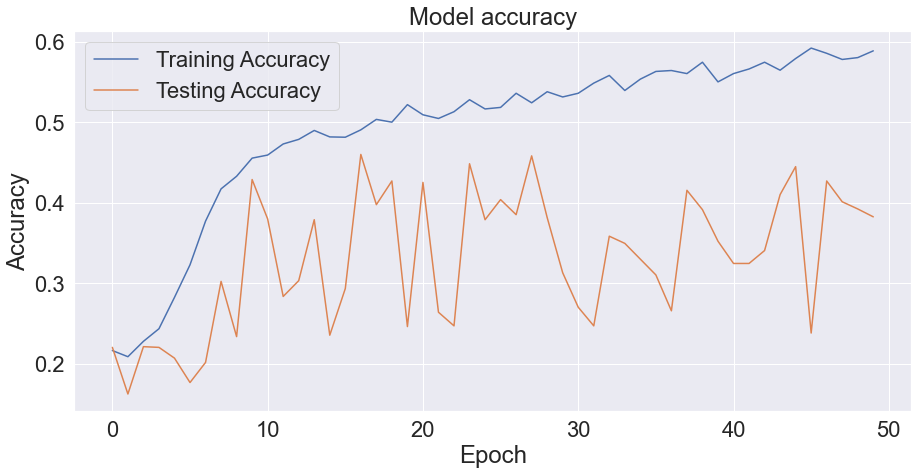

In [87]:
# Plot Accuracy.
plt.figure(figsize=(15, 7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='best')
plt.show()

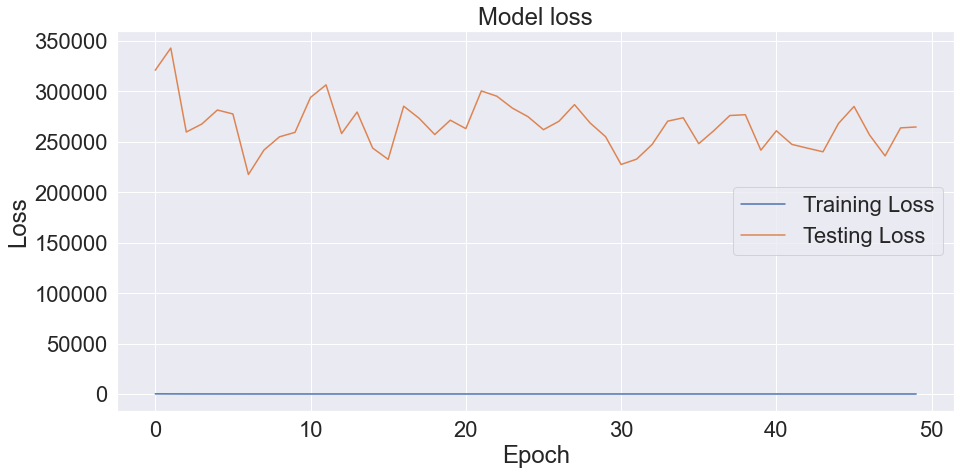

In [88]:
# Plot Loss.
plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Testing Loss'], loc='best')
plt.show()

In [89]:
# Making the predictions.
predictions = (model.predict(x_test))
predictions = scaler.inverse_transform(predictions)

print('Predictions Shape:', predictions.shape)
print('\nFirst 10 Predictions:\n', predictions[:10])
print('\nFirst 10 Actual Values:\n', scaler.inverse_transform(y_test[:10]))
print('\nLast 10 Predictions:\n', predictions[-10:])
print('\nLast 10 Actual Values:\n', scaler.inverse_transform(y_test[-10:]))

Predictions Shape: (1122, 5)

First 10 Predictions:
 [[44.542778 42.23177  43.2684   42.95283  42.388416]
 [41.21469  44.967934 43.753345 41.316414 45.590637]
 [42.6874   44.263306 41.128162 44.26884  43.334587]
 [42.07517  43.069622 44.93483  41.825542 44.965855]
 [41.369453 46.446205 42.95031  43.483562 44.368286]
 [44.20617  43.409634 44.044212 42.6706   42.119816]
 [42.06885  45.333965 43.74593  40.512363 45.73666 ]
 [43.275547 43.94135  40.205593 44.98177  41.56248 ]
 [42.47847  42.035564 45.333073 40.326374 44.47143 ]
 [40.14248  46.881924 41.570152 42.63547  45.170856]]

First 10 Actual Values:
 [[45.926 44.138 44.248 42.87  41.808]
 [44.138 44.248 42.87  41.808 46.37 ]
 [44.248 42.87  41.808 46.37  44.6  ]
 [42.87  41.808 46.37  44.6   43.356]
 [41.808 46.37  44.6   43.356 43.95 ]
 [46.37  44.6   43.356 43.95  39.342]
 [44.6   43.356 43.95  39.342 46.268]
 [43.356 43.95  39.342 46.268 43.356]
 [43.95  39.342 46.268 43.356 44.578]
 [39.342 46.268 43.356 44.578 42.606]]

Last 10 

In [90]:
# Getting the average value for all the predictions.
average_predictions = [predictions[0][0], (predictions[0][1] + predictions[1][0]) / 2,
                       (predictions[0][2] + predictions[1][1] + predictions[2][0]) / 3,
                       (predictions[0][3] + predictions[1][2] + predictions[2][1] + predictions[3][0]) / 4]

for i in range(len(predictions) - 4):
    average_predictions.append((predictions[i][4] + predictions[i + 1][3] + predictions[i + 2][2] + predictions[i + 3][
        1] + predictions[i + 4][0]) / 5)

average_predictions.append((predictions[-1][1] + predictions[-2][2] + predictions[-3][3] + predictions[-4][4]) / 4)
average_predictions.append((predictions[-1][2] + predictions[-2][3] + predictions[-3][4]) / 3)
average_predictions.append((predictions[-1][3] + predictions[-2][4]) / 2)
average_predictions.append(predictions[-1][4])

print('\nAverage Predictions Length:', len(average_predictions))
# print('\nAverage Predictions:\n', average_predictions)


Average Predictions Length: 1126


In [91]:
# Calculating the errors. # Here we identify the anomalies using Absolute Percentage Error.


# Creating the comparison dataset.
comparison_cpu_utilization = cpu_utilization['value'].values[len(x_train) + window:]

print('Length of the comparison dataset:', len(comparison_cpu_utilization))

absolute_percentage_errors = []
for i in range(len(average_predictions)):
    absolute_percentage_errors.append(abs((comparison_cpu_utilization[i]-average_predictions[i])/comparison_cpu_utilization[i]) * 100)

# Printing some statistics about the errors.
print('\nMaximum Absolute Percentage Error Value:', max(absolute_percentage_errors))
print('\nMinimum Absolute Percentage Error Value', min(absolute_percentage_errors))
print('\nMean Absolute Percentage Error Value:', np.mean(absolute_percentage_errors))
print('\nMedian Absolute Percentage Error Value:', np.median(absolute_percentage_errors))
print('\nStandard Deviation of Absolute Percentage Error Values:', np.std(absolute_percentage_errors))

# Calculating the threshold.
threshold = np.mean(absolute_percentage_errors) + 2 * np.std(absolute_percentage_errors)
print('\nThreshold:', threshold)

Length of the comparison dataset: 1126

Maximum Absolute Percentage Error Value: 39.86315195858636

Minimum Absolute Percentage Error Value 0.000506757029957096

Mean Absolute Percentage Error Value: 3.3215988647558023

Median Absolute Percentage Error Value: 2.8427577476773442

Standard Deviation of Absolute Percentage Error Values: 2.720854376368555

Threshold: 8.763307617492913


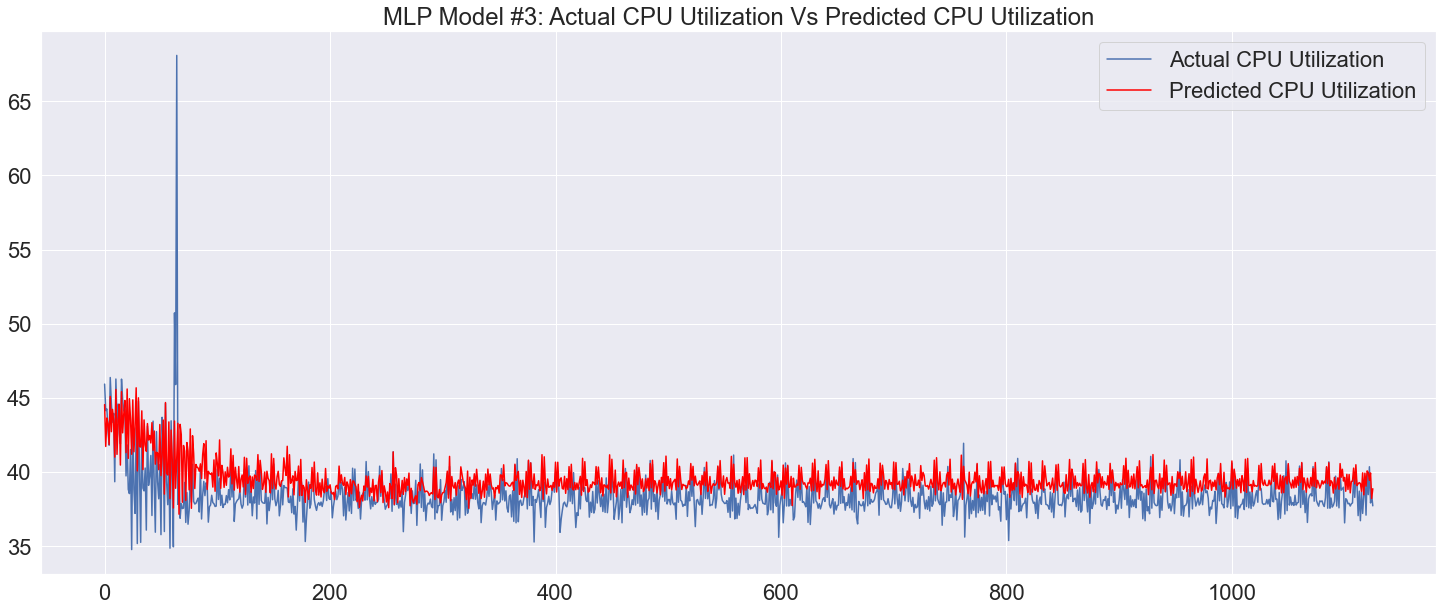

In [92]:
# Plotting the Actual CPU Utilization vs Predicted CPU Utilization.
plt.figure(figsize=(25, 10))
plt.plot(comparison_cpu_utilization, label='Actual CPU Utilization')
plt.plot(average_predictions, label='Predicted CPU Utilization', color='red')
plt.legend()
plt.title('MLP Model #3: Actual CPU Utilization Vs Predicted CPU Utilization')
plt.show()

In [93]:
# Getting the anomaly indices.
anomalies = []
for absolute_percentage_error in absolute_percentage_errors:
    if absolute_percentage_error > threshold:
        anomalies.append(absolute_percentage_error)
        
print('Length of anomalies:', len(anomalies))

anomaly_indices = []
for anomaly in anomalies:
    anomaly_indices.append(absolute_percentage_errors.index(anomaly))
print('\nAnomaly Indices:', anomaly_indices)

Length of anomalies: 33

Anomaly Indices: [20, 22, 24, 27, 29, 32, 35, 37, 42, 44, 45, 50, 58, 62, 63, 64, 65, 67, 68, 70, 74, 92, 99, 144, 170, 367, 381, 404, 524, 598, 602, 763, 802]


In [94]:
# Creating the anomalies dataset.
anomalies_dataset = []
for i in range(len(x_test) + predict - 1):
    if i in anomaly_indices:
        anomalies_dataset.append(comparison_cpu_utilization[i])
    else:
        anomalies_dataset.append(None)
        
# print((anomalies_dataset))

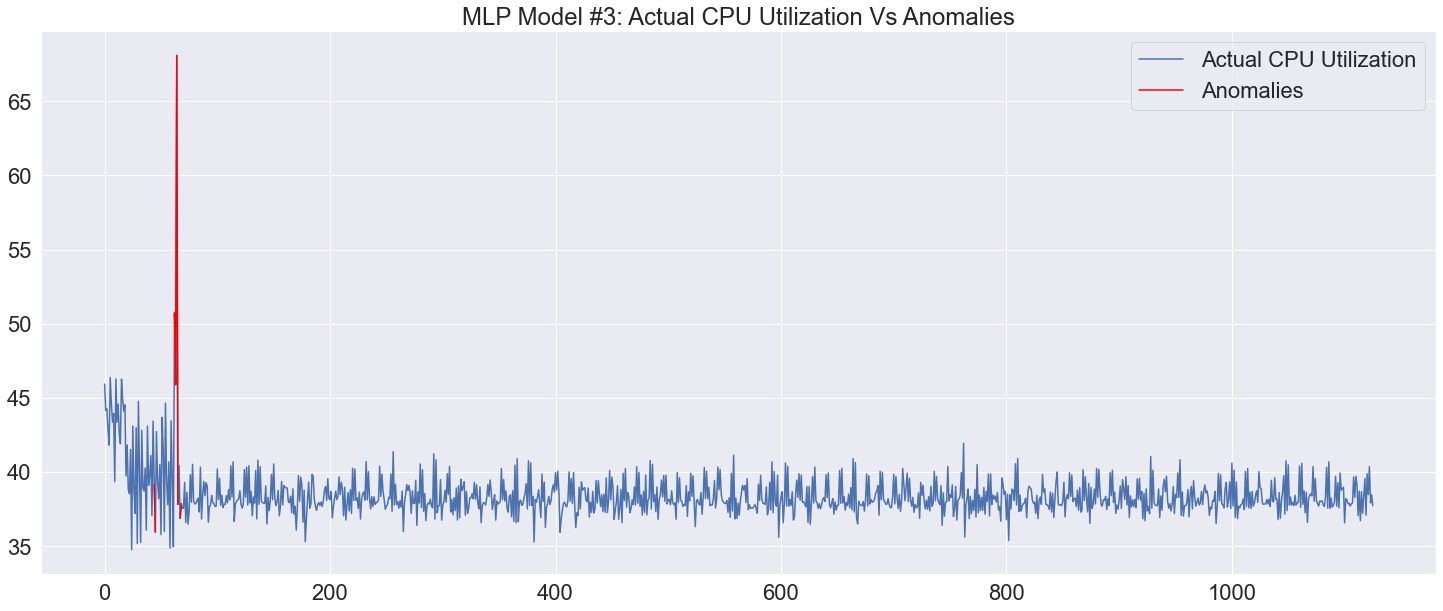

In [95]:
# Plotting the Actual CPU Utilization vs Predicted CPU Utilization.
plt.figure(figsize=(25, 10))
plt.plot(comparison_cpu_utilization, label='Actual CPU Utilization')
plt.plot(anomalies_dataset, label='Anomalies', color='red')
plt.legend()
plt.title('MLP Model #3: Actual CPU Utilization Vs Anomalies')
plt.show()

In [96]:
# Getting the predicted classes for plotting the confusion matrix.
normal_anomaly_predictions = []
for i in range(len(x_test) + predict - 1):
    if i in anomaly_indices:
        normal_anomaly_predictions.append('anomaly')
    else:
        normal_anomaly_predictions.append('normal')

# Getting the hypothesized classes for plotting the confusion matrix.
comparison_cpu_utilization_label = cpu_utilization['Label'].values[len(x_train) + window:]

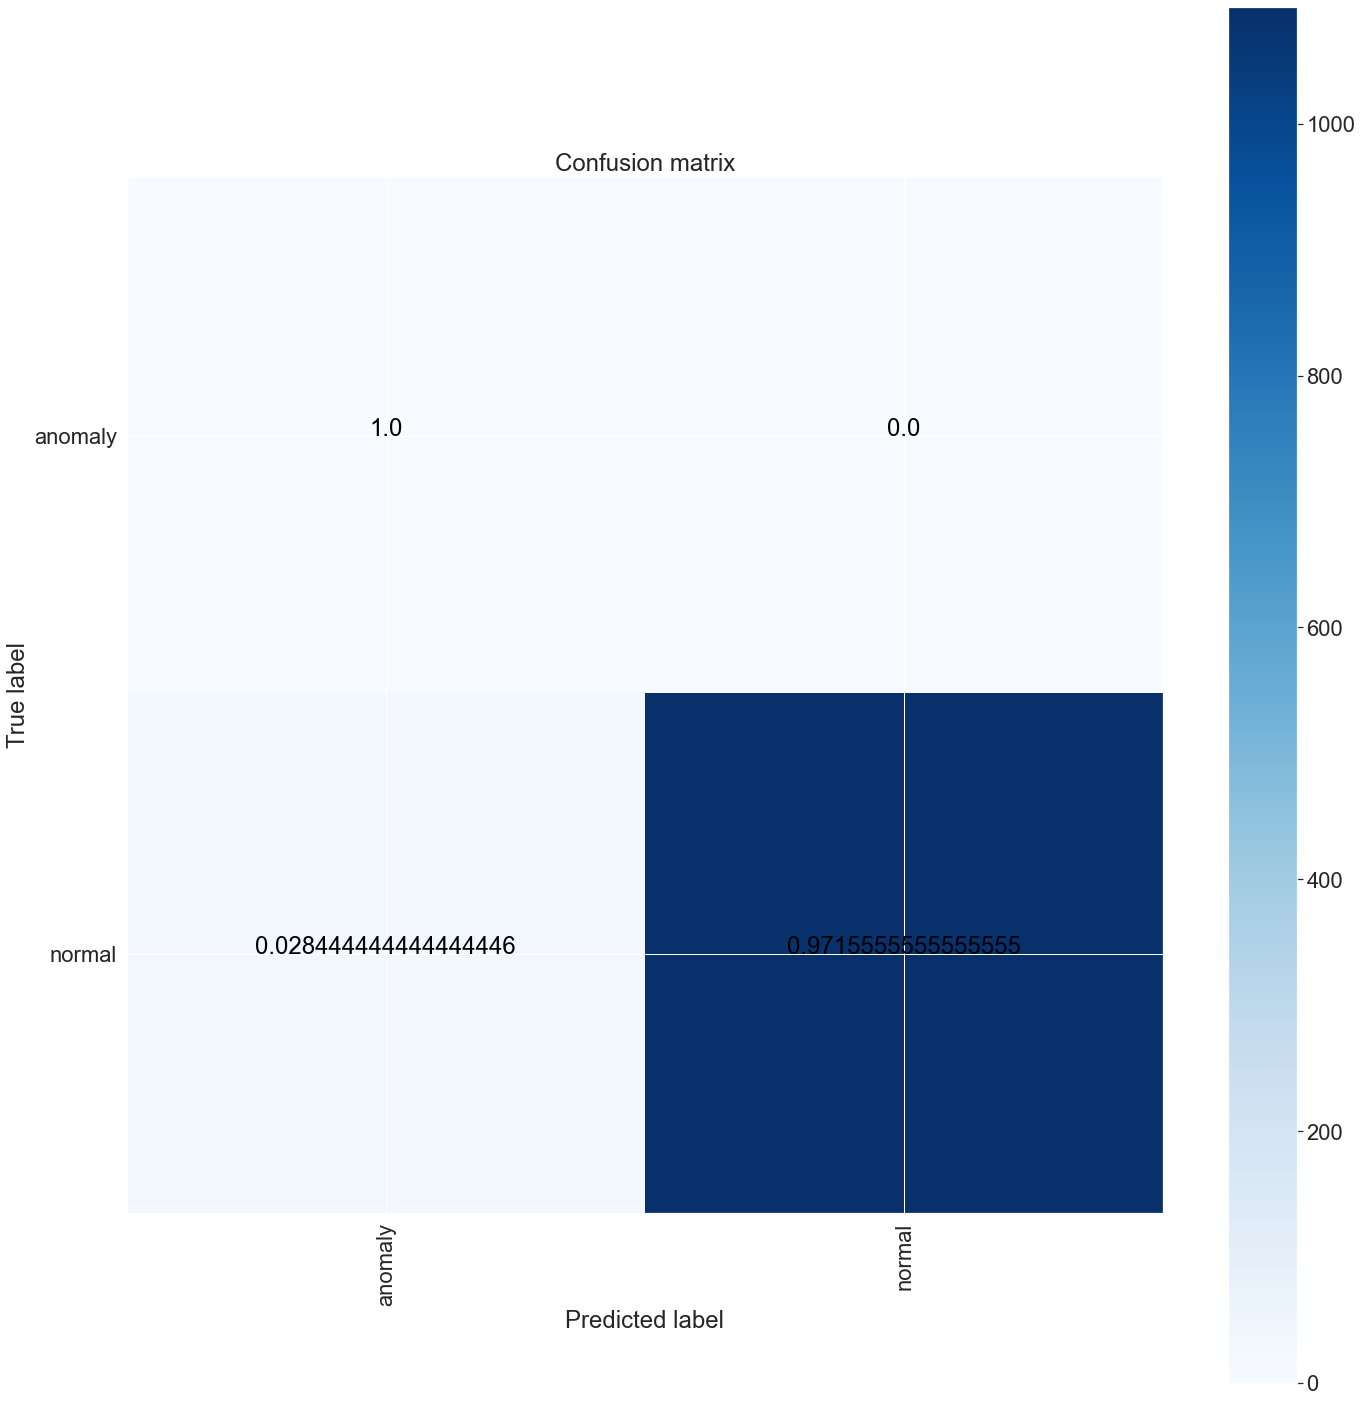

In [97]:
# Plotting the confusion matrix.
confusion_mtx = confusion_matrix(comparison_cpu_utilization_label, normal_anomaly_predictions)
plt.figure(figsize=(20, 20))
sns.set(font_scale=2.0)
plot_confusion_matrix(confusion_mtx, classes=['anomaly', 'normal'])

# LSTM Model #3

In [98]:
# Reshaping.
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [99]:
# LSTM Model #3 with the loss as 'Mean Absolute Percentage Error'.
model = Sequential()
model.add(LSTM(units=384, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=192, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(predict))

model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['accuracy'])

In [100]:
# Fitting the model on the training data.
history = model.fit(x_train, y_train, epochs=20, batch_size=128, verbose=1, validation_data=(x_test, y_test))

Epoch 1/20
21/21 [==============================] - 5s 240ms/step - loss: 82.2493 - accuracy: 0.2131 - val_loss: 411662.4062 - val_accuracy: 0.2041
Epoch 2/20
21/21 [==============================] - 5s 220ms/step - loss: 31.0479 - accuracy: 0.1960 - val_loss: 349876.7500 - val_accuracy: 0.2094
Epoch 3/20
21/21 [==============================] - 5s 221ms/step - loss: 29.0896 - accuracy: 0.1849 - val_loss: 337339.9375 - val_accuracy: 0.2139
Epoch 4/20
21/21 [==============================] - 5s 221ms/step - loss: 28.6660 - accuracy: 0.2131 - val_loss: 318224.9062 - val_accuracy: 0.2059
Epoch 5/20
21/21 [==============================] - 5s 219ms/step - loss: 28.6053 - accuracy: 0.1917 - val_loss: 313835.3438 - val_accuracy: 0.2059
Epoch 6/20
21/21 [==============================] - 5s 220ms/step - loss: 28.6827 - accuracy: 0.2002 - val_loss: 328204.8125 - val_accuracy: 0.2059
Epoch 7/20
21/21 [==============================] - 5s 218ms/step - loss: 28.5750 - accuracy: 0.1898 - val_loss:

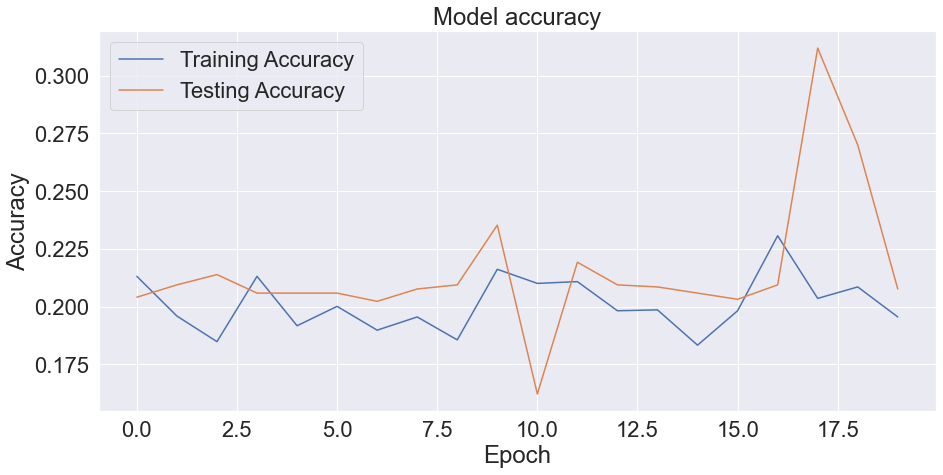

In [101]:
# Plot Accuracy.
plt.figure(figsize=(15, 7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='best')
plt.show()

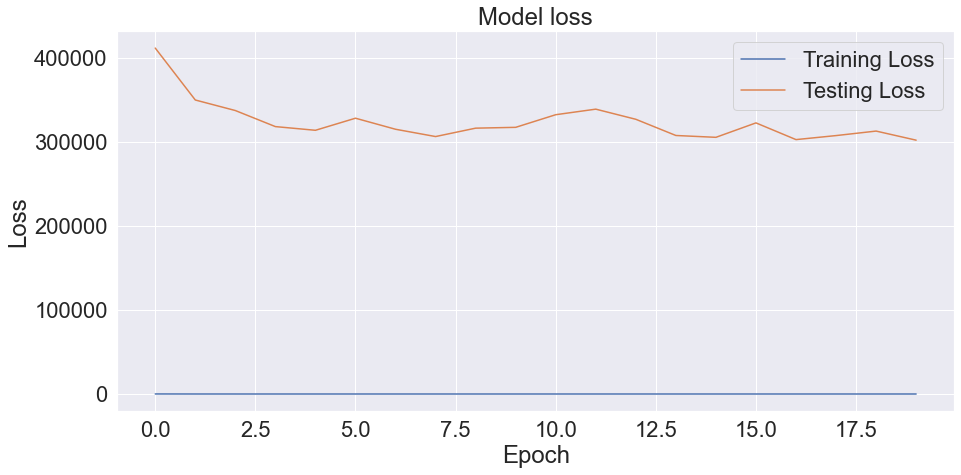

In [102]:
# Plot Loss.
plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Testing Loss'], loc='best')
plt.show()

In [103]:
# Making the predictions.
predictions = (model.predict(x_test))
predictions = scaler.inverse_transform(predictions)

print('Predictions Shape:', predictions.shape)
print('\nFirst 10 Predictions:\n', predictions[:10])
print('\nFirst 10 Actual Values:\n', scaler.inverse_transform(y_test[:10]))
print('\nLast 10 Predictions:\n', predictions[-10:])
print('\nLast 10 Actual Values:\n', scaler.inverse_transform(y_test[-10:]))

Predictions Shape: (1122, 5)

First 10 Predictions:
 [[41.842014 42.305943 42.094273 42.16513  42.206593]
 [41.840927 42.32846  42.078655 42.18559  42.201138]
 [41.85166  42.334396 42.094563 42.186523 42.202297]
 [41.86435  42.335667 42.10545  42.17934  42.199646]
 [41.871014 42.342033 42.102154 42.178757 42.187252]
 [41.878284 42.346867 42.08709  42.17774  42.170662]
 [41.877117 42.341103 42.080444 42.1628   42.16668 ]
 [41.873405 42.34629  42.053864 42.17255  42.15259 ]
 [41.871143 42.329147 42.062267 42.155746 42.161106]
 [41.860733 42.33313  42.044857 42.17127  42.158554]]

First 10 Actual Values:
 [[45.926 44.138 44.248 42.87  41.808]
 [44.138 44.248 42.87  41.808 46.37 ]
 [44.248 42.87  41.808 46.37  44.6  ]
 [42.87  41.808 46.37  44.6   43.356]
 [41.808 46.37  44.6   43.356 43.95 ]
 [46.37  44.6   43.356 43.95  39.342]
 [44.6   43.356 43.95  39.342 46.268]
 [43.356 43.95  39.342 46.268 43.356]
 [43.95  39.342 46.268 43.356 44.578]
 [39.342 46.268 43.356 44.578 42.606]]

Last 10 

In [104]:
# Getting the average value for all the predictions.
average_predictions = [predictions[0][0], (predictions[0][1] + predictions[1][0]) / 2,
                       (predictions[0][2] + predictions[1][1] + predictions[2][0]) / 3,
                       (predictions[0][3] + predictions[1][2] + predictions[2][1] + predictions[3][0]) / 4]

for i in range(len(predictions) - 4):
    average_predictions.append((predictions[i][4] + predictions[i + 1][3] + predictions[i + 2][2] + predictions[i + 3][
        1] + predictions[i + 4][0]) / 5)

average_predictions.append((predictions[-1][1] + predictions[-2][2] + predictions[-3][3] + predictions[-4][4]) / 4)
average_predictions.append((predictions[-1][2] + predictions[-2][3] + predictions[-3][4]) / 3)
average_predictions.append((predictions[-1][3] + predictions[-2][4]) / 2)
average_predictions.append(predictions[-1][4])

print('\nAverage Predictions Length:', len(average_predictions))
# print('\nAverage Predictions:\n', average_predictions)


Average Predictions Length: 1126


In [105]:
# Calculating the errors. # Here we identify the anomalies using Absolute Percentage Error.


# Creating the comparison dataset.
comparison_cpu_utilization = cpu_utilization['value'].values[len(x_train) + window:]

print('Length of the comparison dataset:', len(comparison_cpu_utilization))

absolute_percentage_errors = []
for i in range(len(average_predictions)):
    absolute_percentage_errors.append(abs((comparison_cpu_utilization[i]-average_predictions[i])/comparison_cpu_utilization[i]) * 100)

# Printing some statistics about the errors.
print('\nMaximum Absolute Percentage Error Value:', max(absolute_percentage_errors))
print('\nMinimum Absolute Percentage Error Value', min(absolute_percentage_errors))
print('\nMean Absolute Percentage Error Value:', np.mean(absolute_percentage_errors))
print('\nMedian Absolute Percentage Error Value:', np.median(absolute_percentage_errors))
print('\nStandard Deviation of Absolute Percentage Error Values:', np.std(absolute_percentage_errors))

# Calculating the threshold.
threshold = np.mean(absolute_percentage_errors) + 2 * np.std(absolute_percentage_errors)
print('\nThreshold:', threshold)

Length of the comparison dataset: 1126

Maximum Absolute Percentage Error Value: 39.3711023981112

Minimum Absolute Percentage Error Value 0.0003486729715347034

Mean Absolute Percentage Error Value: 2.6295292241468826

Median Absolute Percentage Error Value: 1.7644340619288048

Standard Deviation of Absolute Percentage Error Values: 2.8440818911879773

Threshold: 8.317693006522838


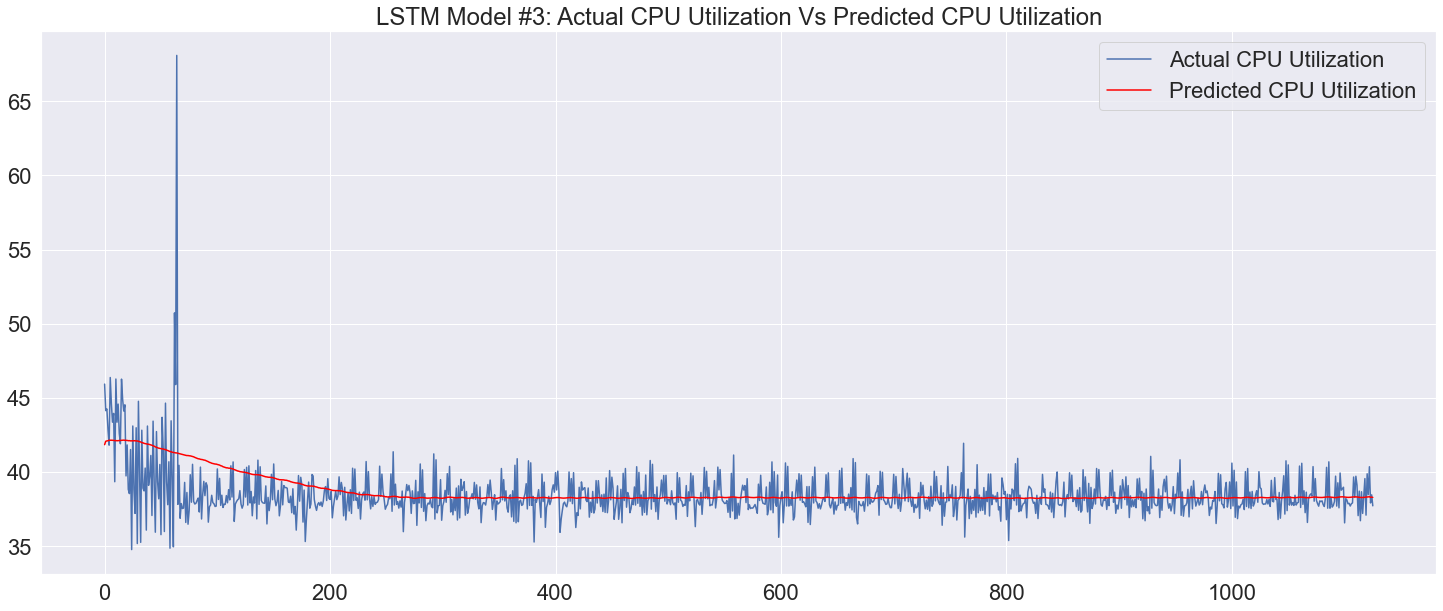

In [106]:
# Plotting the Actual CPU Utilization vs Predicted CPU Utilization.
plt.figure(figsize=(25, 10))
plt.plot(comparison_cpu_utilization, label='Actual CPU Utilization')
plt.plot(average_predictions, label='Predicted CPU Utilization', color='red')
plt.legend()
plt.title('LSTM Model #3: Actual CPU Utilization Vs Predicted CPU Utilization')
plt.show()

In [107]:
# Getting the anomaly indices.
anomalies = []
for absolute_percentage_error in absolute_percentage_errors:
    if absolute_percentage_error > threshold:
        anomalies.append(absolute_percentage_error)
        
print('Length of anomalies:', len(anomalies))

anomaly_indices = []
for anomaly in anomalies:
    anomaly_indices.append(absolute_percentage_errors.index(anomaly))
print('\nAnomaly Indices:', anomaly_indices)

Length of anomalies: 40

Anomaly Indices: [0, 5, 10, 15, 21, 22, 24, 26, 27, 29, 32, 37, 42, 45, 48, 50, 53, 56, 58, 61, 62, 63, 64, 65, 67, 68, 69, 70, 72, 74, 75, 84, 86, 92, 115, 144, 170, 178, 381, 762]


In [108]:
# Creating the anomalies dataset.
anomalies_dataset = []
for i in range(len(x_test) + predict - 1):
    if i in anomaly_indices:
        anomalies_dataset.append(comparison_cpu_utilization[i])
    else:
        anomalies_dataset.append(None)
        
# print((anomalies_dataset))

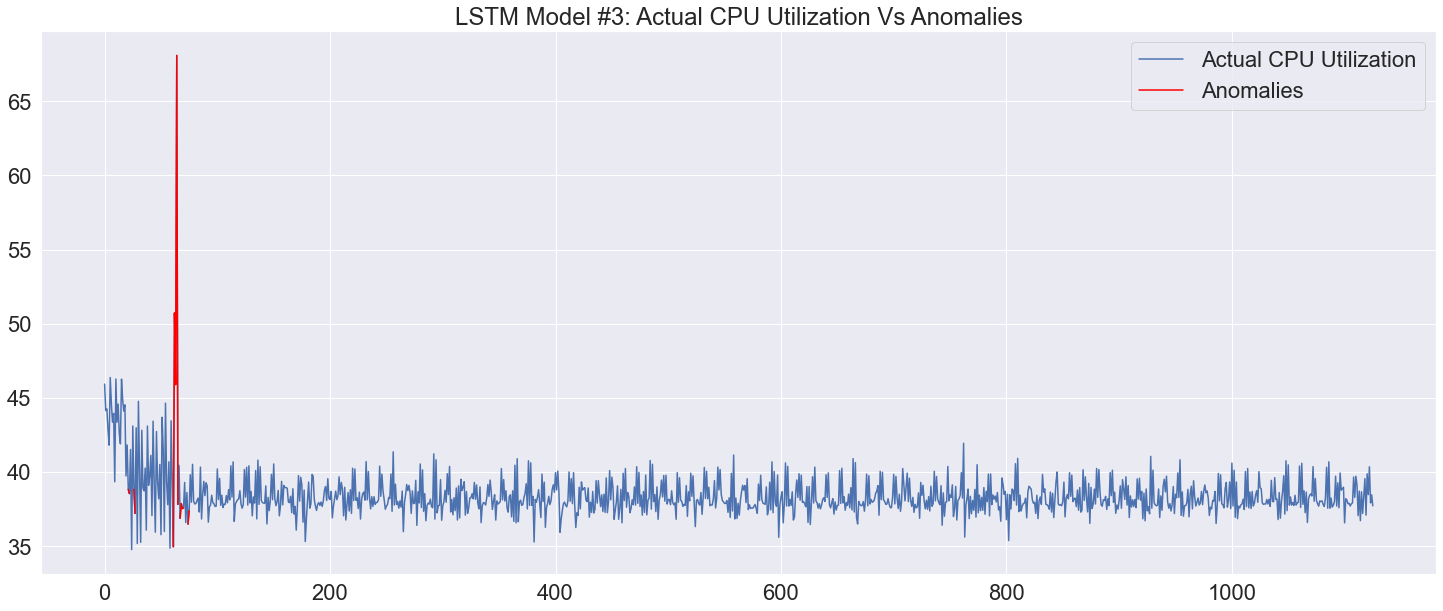

In [109]:
# Plotting the Actual CPU Utilization vs Predicted CPU Utilization.
plt.figure(figsize=(25, 10))
plt.plot(comparison_cpu_utilization, label='Actual CPU Utilization')
plt.plot(anomalies_dataset, label='Anomalies', color='red')
plt.legend()
plt.title('LSTM Model #3: Actual CPU Utilization Vs Anomalies')
plt.show()

In [110]:
# Getting the predicted classes for plotting the confusion matrix.
normal_anomaly_predictions = []
for i in range(len(x_test) + predict - 1):
    if i in anomaly_indices:
        normal_anomaly_predictions.append('anomaly')
    else:
        normal_anomaly_predictions.append('normal')

# Getting the hypothesized classes for plotting the confusion matrix.
comparison_cpu_utilization_label = cpu_utilization['Label'].values[len(x_train) + window:]

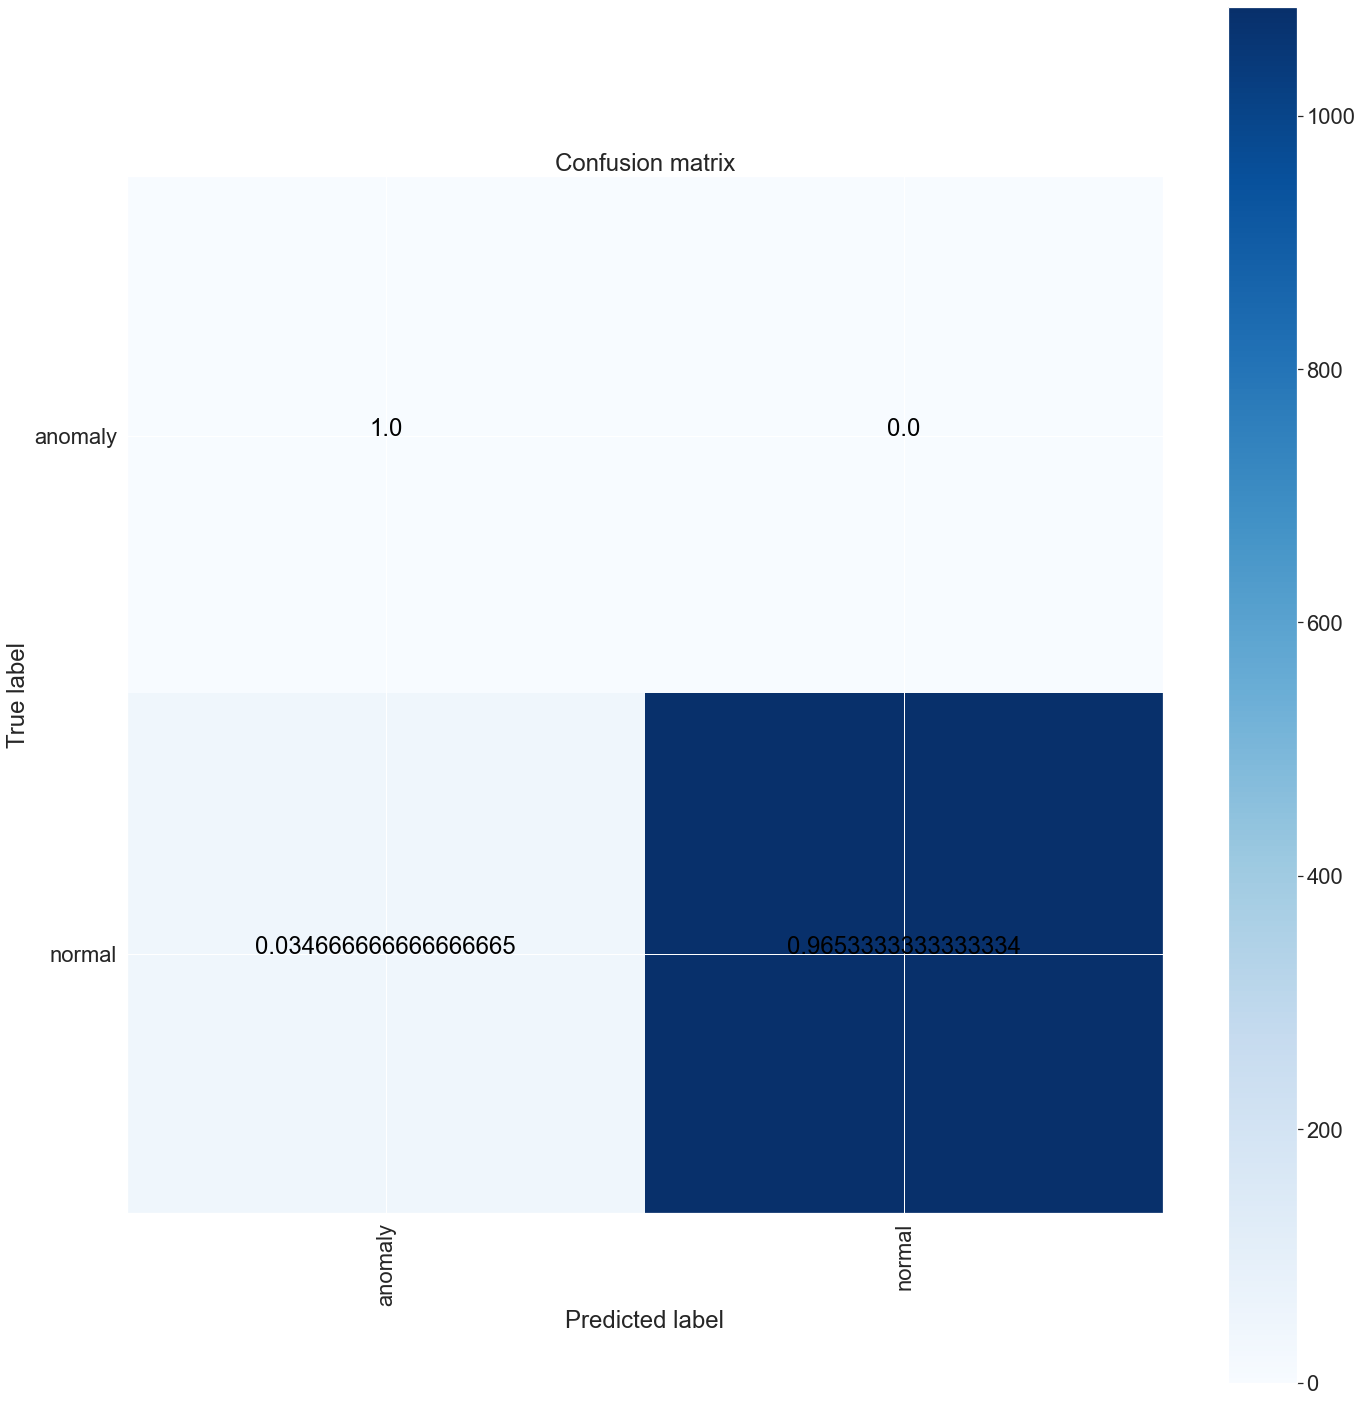

In [111]:
# Plotting the confusion matrix.
confusion_mtx = confusion_matrix(comparison_cpu_utilization_label, normal_anomaly_predictions)
plt.figure(figsize=(20, 20))
sns.set(font_scale=2.0)
plot_confusion_matrix(confusion_mtx, classes=['anomaly', 'normal'])

# Comment on Results:

We can see that the MLP models make better predictions than the LSTM models. The loss values for MLP models are lower than that of LSTM models. Also, LSTM doesn't perform as well with smaller window sizes. The LSTM model makes smooth predictions if we use three layers instead of two. 